<a href="https://colab.research.google.com/github/chriskestri/portfolio/blob/main/Imbalanced%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic 6: Class Imbalance
Applied Predictive Analytics Seminar
SoSe '22





616912 Christos Kestritsalis

582824 Ha My Nguyen

613826 Akanksha Saxena

620146 Sinan Wang


# 1 . Introduction

**Data imbalance** in binary classification describes a dataset in which there are proportionately significantly less instances of the positive class, also called **minority** class, in relation to the negative class, also called **majority** class. Similarly, for multiclass classification there would be proportionately less instances of one class compared to the other classes. The case of imbalanced class distribution poses different challenges in classification and prediction. A classification model needs to be trained to handle these challenges in order for it to perform well when applied to new data.


In this computational notebook we introduce most popular approaches to class imbalance and assess their performance when applied to a credit dataset with a binary target variable.

##1.1 Causes of class imbalance

Imbalanced class distribution is not a phenomenon exclusively observed in the credit risk domain. It occurs in many domain applications, e.g. cybersecurity and medical diagnosis.

Apart from bias introduced in the data collection process because of errors in sampling (e.g. wrong labeling of data) there are two causes for imbalanced class distribution related to the property of the domain. First of all, imbalance can be an **instrinsic** problem which means that the occurence of the minority class is naturally rare (e.g. credit card fraud, rare disease detection) [1].

On the other hand, reasons for class imbalance can be **extrinsic**. While the class distribution may not be naturally skewed, it can be expensive to retrieve a balanced, well-represented dataset because it is costly, the data is subject to confidentiality or it is just hard to get the data [1].

## 1.2 Challenges of class imbalance [1]


**Failure of standard classifiers and global prediction measures**

Standard classifiers such as logistic regression do  not perform well on imbalanced data as they are **accuracy-driven** which is not a suitable measure as a high accuracy can be **deceptive** when dealing with imbalanced datasets.

For example, when you have 100 instances of which 99 belong to the majority class and one belongs to the minority class, a standard classifier trying to maximize the accuracy will achieve a very high accuracy score of 99% by classifying all of them as belonging to the negative class. However, one instance of the positive class has been misclassified. This is harmful as in most applications the **minority class is the class of interest** and typically has **higher error cost** (misclassification cost) than the positive class, i.e. false negatives are more expensive than false positives. As accuracy is in that sense deceptive it is not a suitable performance measure and accuracy-driven classifiers will not have a good recognition rate for the minority class.

Another weakness of standard classifiers which hinders learning of the minorty class is that they assume **similar distribution among classes** and assume **similar error cost for classes**. If standard classifiers do not take actual underlying distribution and different error cost into account, this will deteriorate the classification performance.

**Small disjuncts**

Small disjuncts can be described as **imbalance within a class**. This within class imbalance adds to the already existent class imbalance and might be not recognized by a classifier.(see picture 1)

**Class overlap**

Also called class complexity, class overlap describes an overlap of occurences from majority and minorty class. This makes it difficult for the classifier to **separate minority class from the majority class** and hinders the learning of the smaller class. Standard classifiers that are accuracy-driven tend to classify instances in the overlapping area as belonging to the majority class, **treating the minority class instances as noise**.

**Rare instances**

Rare occurences and outliers of a class are likely **treated as noise** especially by accuracy-driven classifiers, therefore ignored and remaining undiscovered.


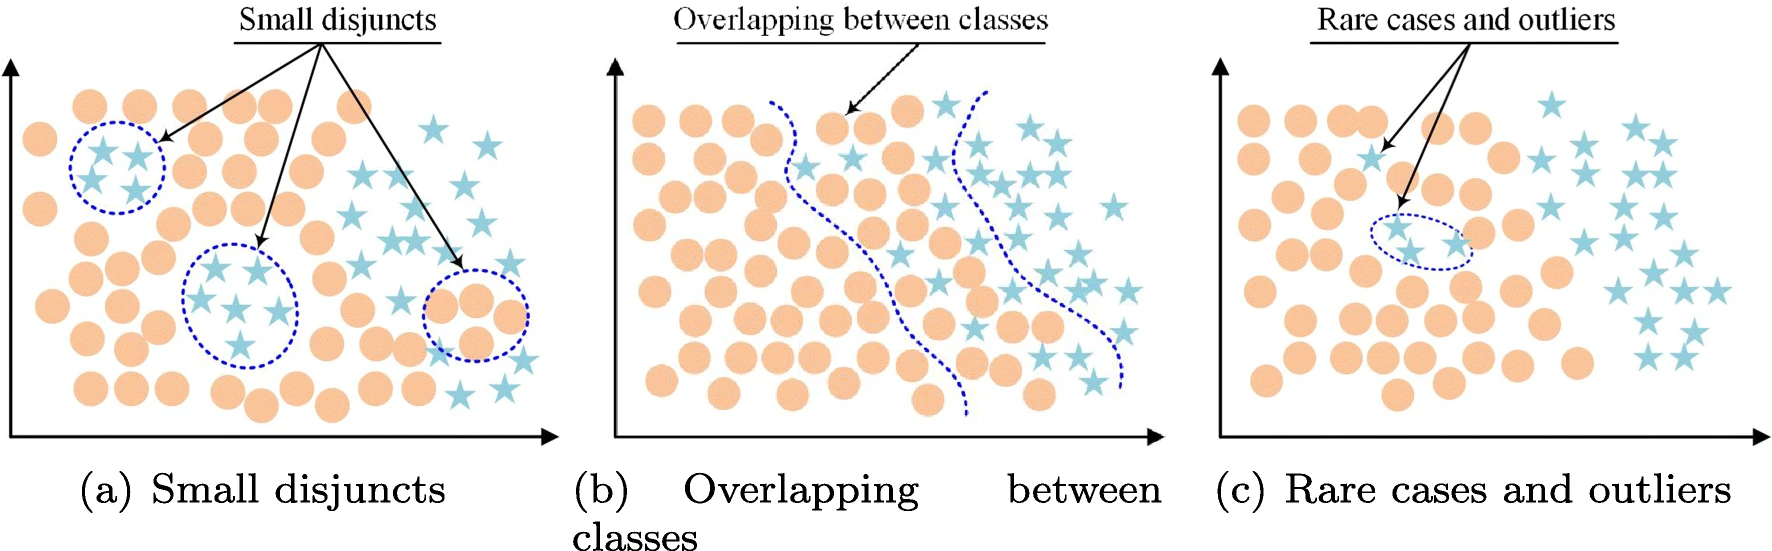
Figure 1: Small disjuncts, class overlap and rare cases and outliers

Reference: https://link.springer.com/article/10.1007/s10489-020-01852-8

All these challenges lead to instances that actually belong to the **minority class being misclassified as majority class instances**. When applied to new data, the classifier will be **biased towards the majority class**. The resulting misclassification or wrong prediction of (actual) minority class cases will prove costly. The overarching **objective** of handling the imbalance is therefore a **minimization of error cost**. Because of these aforementioned challenges, it is important to tackle the class imbalance and we are going to introduce the approaches at different stages when dealing with our credit risk dataset.

## 1.3. Data import, EDA and data cleaning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings
from imblearn.metrics import classification_report_imbalanced, make_index_balanced_accuracy, geometric_mean_score
from google.colab import files
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore')

random_state = 0 # use for all models

# import training set
df = pd.read_csv('https://raw.githubusercontent.com/chriskestri/APA/main/data_train.csv', low_memory=False)

# import test set
x_test = pd.read_csv('https://raw.githubusercontent.com/chriskestri/APA/main/x_test.csv')

print("train dataset dimensinality:", df.shape, end='\n\n')

df.head()

train dataset dimensinality: (149985, 32)



,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,cnt_borr,seller_name,servicer_name,flag_sc,pre_relief,pgrm_ind,rel_ref_ind,prop_val_meth,int_only_ind,TARGET
0,726,201504,N,204503,47260.0,0,1,P,66,36,...,2,QUICKEN LOANS INC.,Other servicers,NaN,NaN,9,NaN,9,N,0
1,794,201505,N,204504,36084.0,0,1,P,76,26,...,1,Other sellers,FREEDOM MORTGAGE CORPORATION,NaN,NaN,9,NaN,9,N,0
2,767,201505,Y,204504,36740.0,0,1,P,80,37,...,1,BRANCH BANKING & TRUST COMPANY,TRUIST BANK,NaN,NaN,9,NaN,9,N,0
3,782,201503,N,204502,NaN,25,1,P,90,21,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,0
4,802,201503,N,203002,14860.0,0,1,P,35,10,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            149985 non-null  int64  
 1   dt_first_pi     149985 non-null  int64  
 2   flag_fthb       149985 non-null  object 
 3   dt_matr         149985 non-null  int64  
 4   cd_msa          129014 non-null  float64
 5   mi_pct          149985 non-null  int64  
 6   cnt_units       149985 non-null  int64  
 7   occpy_sts       149985 non-null  object 
 8   cltv            149985 non-null  int64  
 9   dti             149985 non-null  int64  
 10  orig_upb        149985 non-null  int64  
 11  ltv             149985 non-null  int64  
 12  int_rt          149985 non-null  float64
 13  channel         149985 non-null  object 
 14  ppmt_pnlty      149985 non-null  object 
 15  prod_type       149985 non-null  object 
 16  st              149985 non-null  object 
 17  prop_type 

In [ ]:
df.describe(include='all')

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,cnt_borr,seller_name,servicer_name,flag_sc,pre_relief,pgrm_ind,rel_ref_ind,prop_val_meth,int_only_ind,TARGET
count,149985.000000,149985.000000,149985,149985.000000,129014.000000,149985.000000,149985.000000,149985,149985.000000,149985.000000,...,149985.000000,149985,149985,5004,26148,149985,26148,149985.0,149985,149985.000000
unique,NaN,NaN,3,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,34,34,1,26148,3,1,NaN,1,NaN
top,NaN,NaN,N,NaN,NaN,NaN,NaN,P,NaN,NaN,...,NaN,Other sellers,Other servicers,Y,A05Q30013523,9,Y,NaN,N,NaN
freq,NaN,NaN,128784,NaN,NaN,NaN,NaN,130237,NaN,NaN,...,NaN,49182,43392,5004,1,149695,26148,NaN,149985,NaN
mean,749.229670,201423.168283,NaN,204004.527413,30325.078240,5.548875,1.031977,NaN,76.214581,201.748475,...,1.521565,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,0.009021
std,90.309748,88.708776,NaN,670.602842,11315.130921,10.957178,0.236608,NaN,21.763190,366.487468,...,0.499536,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.094549
min,436.000000,201302.000000,NaN,202102.000000,10180.000000,0.000000,1.000000,NaN,2.000000,1.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,0.000000
25%,717.000000,201312.000000,NaN,203403.000000,19300.000000,0.000000,1.000000,NaN,66.000000,28.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,0.000000
50%,759.000000,201409.000000,NaN,204401.000000,31700.000000,0.000000,1.000000,NaN,80.000000,37.000000,...,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,0.000000
75%,788.000000,201506.000000,NaN,204501.000000,40060.000000,0.000000,1.000000,NaN,89.000000,45.000000,...,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,0.000000


In [ ]:
df.TARGET.describe()

count    149985.000000
mean          0.009021
std           0.094549
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

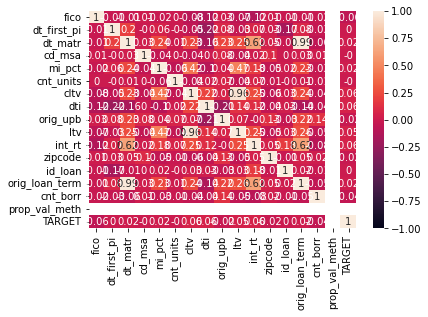

In [ ]:
# correlation plot
sns.heatmap(df.corr().round(2),
            annot=True,
            vmax=1,
            vmin=-1,
            # mask =
            )
#cltv, ltc have similar information
#dt_matr and orig_loan_term highly correlated

### a. Check for nulls

In [ ]:
df.isnull().sum() #cd_,msa, pre_relief--remove(ignore the na values here)

fico                   0
dt_first_pi            0
flag_fthb              0
dt_matr                0
cd_msa             20971
mi_pct                 0
cnt_units              0
occpy_sts              0
cltv                   0
dti                    0
orig_upb               0
ltv                    0
int_rt                 0
channel                0
ppmt_pnlty             0
prod_type              0
st                     0
prop_type              0
zipcode                0
id_loan                0
loan_purpose           0
orig_loan_term         0
cnt_borr               0
seller_name            0
servicer_name          0
flag_sc           144981
pre_relief        123837
pgrm_ind               0
rel_ref_ind       123837
prop_val_meth          0
int_only_ind           0
TARGET                 0
dtype: int64

We notice that there are null-values in cd_msa, flag_sc, pre_relief and rel_ref_ind - we will be dealing with those values at the next part.

### b. Outliers inspect for numerial variables

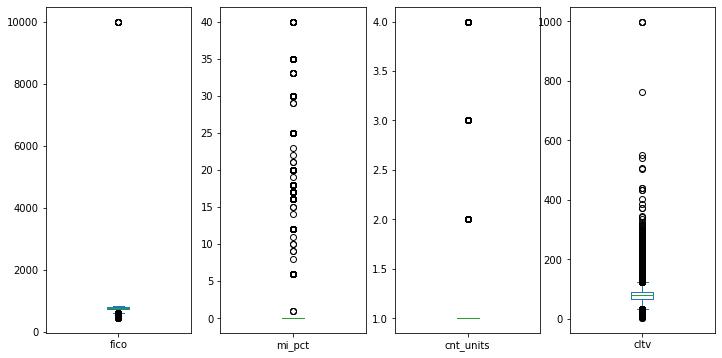

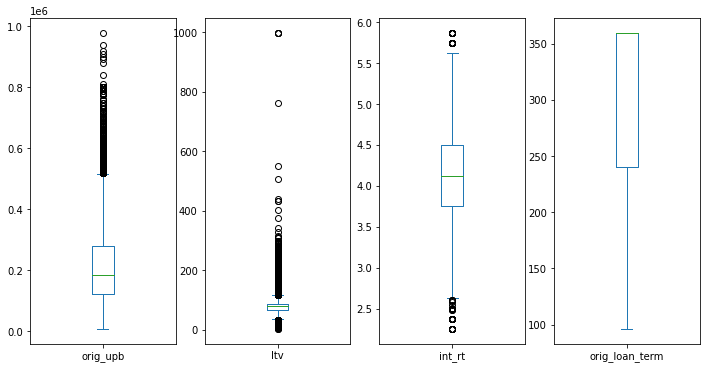

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
num_vars = df[['fico','mi_pct','cnt_units','cltv','orig_upb','ltv','int_rt','orig_loan_term']]
half = np.ceil(num_vars.shape[1] / 2).astype(int)
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);
#extreme 999/9999 outliers are n/a values

### c. Data preparation/cleaning

In the following we deal with the outliers and N/A values.

In [ ]:
# fico: -> not ok 9999 means not available, replace 9999 with mean
df.fico[df.fico ==9999] = df.fico[df.fico !=9999].mean()

# dt_first_pi --> convert to date, possibly remove as duration is available in orig_loan_term
df['dt_first_pi'] = pd.to_datetime(df['dt_first_pi'])
df['dt_matr'] = pd.to_datetime(df['dt_matr']) #sinan
# flag_fthb: categorical -> done see at the bottom, dummy coded later

# dt_matr: date, we have the duration so possibly drop
#df.drop('dt_matr', inplace=True, axis=1, errors='ignore'), we'll drop it when we work with the data maybe

# mi_pct: OK
# cnt_units: OK

# occpy_sts: categorical -> done see at the top
#df['occpy_sts'] = df['occpy_sts'].astype('category')

# cltv: ratio, has 999 for 4 rows--> impute mean
# first compute mean without value 999
df.cltv[df.cltv ==999] = df.cltv[df.cltv !=999].mean()


#  dti: 26k 999s (not available) check with Victor for ideas how to deal with those
#Victor maybe discretize and make 999 one own category
#df["dti_dis"] = df["dti"]

#df.dti_dis[df.dti_dis <= 10] = 1
#df.dti_dis[(df.dti_dis>10) & (df.dti_dis <= 20)] = 2
#df.dti_dis[(df.dti_dis>20) & (df.dti_dis <= 30)] = 3
#df.dti_dis[(df.dti_dis>30) & (df.dti_dis <= 40)] = 4
#df.dti_dis[(df.dti_dis>40) & (df.dti_dis <= 50)] = 5
#df.dti_dis[df.dti_dis == 999] = "Not available"
#df['dti_dis'] = df['dti_dis'].astype('category')


# orig_upb: loan amount OK

# ltv: ratio, 4 '999'--> impute node/mean
df.ltv[df.ltv ==999] = df.ltv[df.ltv !=999].mean()

# int_rt: OK
# channel: category OK
# ppmt_pnlty: one value--> remove
# prod_type: one value--> remove
# st: categorical
# prop_type: categorical, possibly OHE later
# zipcode: convert to text
df['zipcode'] = df['zipcode'].astype('category')
# id_loan: index, convert to text
df['id_loan'] = df['id_loan'].astype('category')
# loan_purpose: OK
# orig_loan_term: loan duration in months, numerical OK
# cnt_borr: 1 or 2, stay as is or convert to bool
df.cnt_borr[df.cnt_borr == 2] = 0
df["cnt_borr"] = df["cnt_borr"].astype("bool")
# seller_name: OK
# servicer_name: OK
# flag_sc: convert to boolea#
df['flag_sc'] = df['flag_sc'].fillna(0)
df.flag_sc[df.flag_sc == "T"] = 1
df["flag_sc"] = df["flag_sc"].astype("bool")

# pre_relief: redundant as it depends on rel_ref_ind--> remove

# pgrm_ind --> convert to categorical
# ?whydf['pgrm_ind'] = df['pgrm_ind'].astype('string') # convert to string to remove duplicates
df['pgrm_ind'] = df['pgrm_ind'].astype('category') # convert to category

# rel_ref_ind: --> convert to boolean
df['rel_ref_ind'] = df['rel_ref_ind'].fillna(0)
df.rel_ref_ind[df.rel_ref_ind == "T"] = 1
df["rel_ref_ind"] = df["rel_ref_ind"].astype("bool")
# prop_val_meth: only one value--> remove
# int_only_ind: remove
# TARGET: the target variable--binary
df['TARGET'] = df['TARGET'].astype('bool') #sinan

#all object to categorical
ob_vars = df.select_dtypes(include=object).columns
df[ob_vars] = df[ob_vars].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fico            149985 non-null  float64       
 1   dt_first_pi     149985 non-null  datetime64[ns]
 2   flag_fthb       149985 non-null  category      
 3   dt_matr         149985 non-null  datetime64[ns]
 4   cd_msa          129014 non-null  float64       
 5   mi_pct          149985 non-null  int64         
 6   cnt_units       149985 non-null  int64         
 7   occpy_sts       149985 non-null  category      
 8   cltv            149985 non-null  float64       
 9   dti             149985 non-null  int64         
 10  orig_upb        149985 non-null  int64         
 11  ltv             149985 non-null  float64       
 12  int_rt          149985 non-null  float64       
 13  channel         149985 non-null  category      
 14  ppmt_pnlty      149985 non-null  cat

We apply the same cleaning procedure to the kaggle dataset.

In [ ]:
# clean colums (Mimi):

# fico: OK -> not ok 9999 means not available
x_test.fico[x_test.fico ==9999] = x_test.fico[x_test.fico !=9999].mean()

# dt_first_pi --> convert to date, possibly remove as duration is available in orig_loan_term
x_test['dt_first_pi'] = pd.to_datetime(x_test['dt_first_pi'])
x_test['dt_matr'] = pd.to_datetime(x_test['dt_matr']) #sinan
# flag_fthb: categorical -> done see at the bottom

# dt_matr: date, we have the duration so possibly drop
#df.drop('dt_matr', inplace=True, axis=1, errors='ignore'), we'll drop it when we work with the data maybe

# mi_pct: OK
# cnt_units: OK

# occpy_sts: categorical -> done see at the top
#df['occpy_sts'] = df['occpy_sts'].astype('category')

# cltv: ratio, has 999 for 4 rows--> impute mean
# first compute mean without value 999
x_test.cltv[x_test.cltv ==999] = x_test.cltv[x_test.cltv !=999].mean()


#  dti: 26k 999s (not available) check with Victor for ideas how to deal with those
#Victor maybe discretize and make 999 one own category
#df["dti_dis"] = df["dti"]

#df.dti_dis[df.dti_dis <= 10] = 1
#df.dti_dis[(df.dti_dis>10) & (df.dti_dis <= 20)] = 2
#df.dti_dis[(df.dti_dis>20) & (df.dti_dis <= 30)] = 3
#df.dti_dis[(df.dti_dis>30) & (df.dti_dis <= 40)] = 4
#df.dti_dis[(df.dti_dis>40) & (df.dti_dis <= 50)] = 5
#df.dti_dis[df.dti_dis == 999] = "Not available"
#df['dti_dis'] = df['dti_dis'].astype('category')


# orig_upb: loan amount OK

# ltv: ratio, 4 '999'--> impute node/mean
x_test.ltv[x_test.ltv ==999] = x_test.ltv[x_test.ltv !=999].mean()

# int_rt: OK
# channel: category OK
# ppmt_pnlty: one value--> remove
# prod_type: one value--> remove
# st: categorical
# prop_type: categorical, possibly OHE later
# zipcode: convert to text
x_test['zipcode'] = x_test['zipcode'].astype('category')
# id_loan: index, convert to text
x_test['id_loan'] = x_test['id_loan'].astype('category')
# loan_purpose: OK
# orig_loan_term: loan duration in months, numerical OK
# cnt_borr: 1 or 2, stay as is or convert to bool
x_test.cnt_borr[x_test.cnt_borr == 2] = 0
x_test["cnt_borr"] = x_test["cnt_borr"].astype("bool")
# seller_name: OK
# servicer_name: OK
# flag_sc: convert to boolea#
x_test['flag_sc'] = x_test['flag_sc'].fillna(0)
x_test.flag_sc[x_test.flag_sc == "T"] = 1
x_test["flag_sc"] = x_test["flag_sc"].astype("bool")

# pre_relief: redundant as it depends on rel_ref_ind--> remove

# pgrm_ind --> convert to categorical
# ?whydf['pgrm_ind'] = df['pgrm_ind'].astype('string') # convert to string to remove duplicates
x_test['pgrm_ind'] = x_test['pgrm_ind'].astype('category') # convert to category

# rel_ref_ind: --> convert to boolean
x_test['rel_ref_ind'] = x_test['rel_ref_ind'].fillna(0)
x_test.rel_ref_ind[x_test.rel_ref_ind == "T"] = 1
x_test["rel_ref_ind"] = x_test["rel_ref_ind"].astype("bool")
# prop_val_meth: only one value--> remove
# int_only_ind: remove
# TARGET: the target variable--binary


#all object to categorical
ob_vars = x_test.select_dtypes(include=object).columns
x_test[ob_vars] = x_test[ob_vars].astype("category")

x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50015 entries, 0 to 50014
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fico            50015 non-null  float64       
 1   dt_first_pi     50015 non-null  datetime64[ns]
 2   flag_fthb       50015 non-null  category      
 3   dt_matr         50015 non-null  datetime64[ns]
 4   cd_msa          44643 non-null  float64       
 5   mi_pct          50015 non-null  int64         
 6   cnt_units       50015 non-null  int64         
 7   occpy_sts       50015 non-null  category      
 8   cltv            50015 non-null  float64       
 9   dti             50015 non-null  int64         
 10  orig_upb        50015 non-null  int64         
 11  ltv             50015 non-null  float64       
 12  int_rt          50015 non-null  float64       
 13  channel         50015 non-null  category      
 14  ppmt_pnlty      50015 non-null  category      
 15  pr

In [ ]:
# exclude some variables
# the features we gonna remove because of redundancy: pre_relief,cd_msa
# the features we gonna remove because of only one level: prop_val_meth(only value is 9),ppmt_pnlty,prod_type,int_only_ind
# the features we gonna remove because of unique identifier: id_loan
df_selected = df.drop(['pre_relief','cd_msa','prop_val_meth', 'ppmt_pnlty','prod_type','int_only_ind','id_loan'], axis = 1)
df_selected.info()
#? the features we might remove because of overlapping of info:dt_first_pi, dt_matr, with orig_loan_term; cd_msa,st with zipcode,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fico            149985 non-null  float64       
 1   dt_first_pi     149985 non-null  datetime64[ns]
 2   flag_fthb       149985 non-null  category      
 3   dt_matr         149985 non-null  datetime64[ns]
 4   mi_pct          149985 non-null  int64         
 5   cnt_units       149985 non-null  int64         
 6   occpy_sts       149985 non-null  category      
 7   cltv            149985 non-null  float64       
 8   dti             149985 non-null  int64         
 9   orig_upb        149985 non-null  int64         
 10  ltv             149985 non-null  float64       
 11  int_rt          149985 non-null  float64       
 12  channel         149985 non-null  category      
 13  st              149985 non-null  category      
 14  prop_type       149985 non-null  cat

In [ ]:
#encode dti_dis--have problem in woe
df_selected["dti_dis"] = df_selected["dti"].astype('category')
df_selected['dti_dis']= pd.DataFrame({'dti_dis':['one','two','three','four','five', 'not available']})
df_selected['dti_dis'] = pd.Categorical(df_selected['dti_dis'])

df_selected.dti_dis[df_selected.dti <= 10] = 'one'
df_selected.dti_dis[(df_selected.dti>10) & (df_selected.dti <= 20)] = 'two'
df_selected.dti_dis[(df_selected.dti>20) & (df_selected.dti <= 30)] = 'three'
df_selected.dti_dis[(df_selected.dti>30) & (df_selected.dti <= 40)] = 'four'
df_selected.dti_dis[(df_selected.dti>40) & (df_selected.dti <= 50)] = 'five'
df_selected.dti_dis[df_selected.dti == 999] = "not available"


In [ ]:
# for test as well
x_test["dti_dis"] = x_test["dti"].astype('category')
x_test['dti_dis']= pd.DataFrame({'dti_dis':['one','two','three','four','five', 'not available']})
x_test['dti_dis'] = pd.Categorical(x_test['dti_dis'])

x_test.dti_dis[x_test.dti <= 10] = 'one'
x_test.dti_dis[(x_test.dti>10) & (x_test.dti <= 20)] = 'two'
x_test.dti_dis[(x_test.dti>20) & (x_test.dti <= 30)] = 'three'
x_test.dti_dis[(x_test.dti>30) & (x_test.dti <= 40)] = 'four'
x_test.dti_dis[(x_test.dti>40) & (x_test.dti <= 50)] = 'five'
x_test.dti_dis[x_test.dti == 999] = "not available"

In [ ]:
#encode pgrm_ind-have problem in woe
df_selected["pgrm_ind2"] = df_selected["pgrm_ind"].astype('category')
df_selected['pgrm_ind2']= pd.DataFrame({'pgrm_ind2':['nine','F','H']})
df_selected['pgrm_ind2'] = pd.Categorical(df_selected['pgrm_ind2'])

df_selected.pgrm_ind2[df_selected.pgrm_ind == 9] = 'nine'
df_selected.pgrm_ind2[df_selected.pgrm_ind == '9'] = 'nine'
df_selected.pgrm_ind2[df_selected.pgrm_ind == 'F'] = 'F'
df_selected.pgrm_ind2[df_selected.pgrm_ind == 'H'] = 'H'

In [ ]:
# for test as well
x_test["pgrm_ind2"] = x_test["pgrm_ind"].astype('category')
x_test['pgrm_ind2']= pd.DataFrame({'pgrm_ind2':['nine','F','H']})
x_test['pgrm_ind2'] = pd.Categorical(x_test['pgrm_ind2'])

x_test.pgrm_ind2[x_test.pgrm_ind == 9] = 'nine'
x_test.pgrm_ind2[x_test.pgrm_ind == '9'] = 'nine'
x_test.pgrm_ind2[x_test.pgrm_ind == 'F'] = 'F'
x_test.pgrm_ind2[x_test.pgrm_ind == 'H'] = 'H'

###Imbalance after cleaning

The imbalance ratio (IR) is defined as following:

IR = number of majority class / number of minority class

The chart below shows the distribution of the positive (true) and negative class (false). After cleaning and preparing the data, around 0.9% of the sample belong to the minority class.

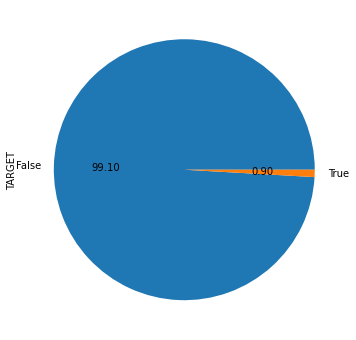

In [ ]:
df.TARGET.value_counts().plot.pie(autopct = "%.2f")

### d. Split into training and validation

In [ ]:
from sklearn.model_selection import train_test_split
# Extract target variable and feature matrix
X = df_selected.drop(['TARGET'], axis=1)
y = df_selected[['TARGET']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=888)

X_train.head()

,fico,dt_first_pi,flag_fthb,dt_matr,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,...,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,pgrm_ind,rel_ref_ind,dti_dis,pgrm_ind2
91697,746.0,1970-01-01 00:00:00.000201602,N,1970-01-01 00:00:00.000204601,0,1,I,70.0,40,214000,...,C,360,True,Other sellers,"ROCKET MORTGAGE, LLC",False,9,False,four,nine
107931,779.0,1970-01-01 00:00:00.000201409,N,1970-01-01 00:00:00.000204408,0,1,P,80.0,46,192000,...,P,360,False,"JPMORGAN CHASE BANK, N.A.","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",False,9,False,five,nine
100677,766.0,1970-01-01 00:00:00.000201409,N,1970-01-01 00:00:00.000204408,0,1,P,52.0,36,439000,...,N,360,True,U.S. BANK N.A.,U.S. BANK N.A.,True,9,False,four,nine
134585,681.0,1970-01-01 00:00:00.000201405,N,1970-01-01 00:00:00.000204404,0,1,P,69.0,40,417000,...,P,360,True,FIFTH THIRD BANK,Other servicers,False,9,False,four,nine
71007,789.0,1970-01-01 00:00:00.000201310,N,1970-01-01 00:00:00.000204309,0,1,P,49.0,32,216000,...,N,360,True,"JPMORGAN CHASE BANK, N.A.","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",False,9,False,four,nine


### e. one hot encoding

In [ ]:
df_selected.pgrm_ind2.value_counts()

nine    149695
H          278
F           12
Name: pgrm_ind2, dtype: int64

In [ ]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

train_len = len(X_train)

X_full = pd.concat(objs=[X_train_scaled, X_test_scaled], axis=0)
X_full = pd.get_dummies(X_full, columns = ['flag_fthb','occpy_sts','channel','loan_purpose', 'pgrm_ind2','dti_dis','prop_type',
                                           'cnt_borr', 'flag_sc', 'rel_ref_ind'], drop_first=True)

X_train_dummies = X_full[:train_len]
X_test_dummies = X_full[train_len:]

X_train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 91697 to 10750
Data columns (total 38 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   fico                   119988 non-null  float64       
 1   dt_first_pi            119988 non-null  datetime64[ns]
 2   dt_matr                119988 non-null  datetime64[ns]
 3   mi_pct                 119988 non-null  int64         
 4   cnt_units              119988 non-null  int64         
 5   cltv                   119988 non-null  float64       
 6   dti                    119988 non-null  int64         
 7   orig_upb               119988 non-null  int64         
 8   ltv                    119988 non-null  float64       
 9   int_rt                 119988 non-null  float64       
 10  st                     119988 non-null  category      
 11  zipcode                119988 non-null  category      
 12  orig_loan_term         119988 non-null  i

In [ ]:
X_full[train_len:]

,fico,dt_first_pi,dt_matr,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,...,dti_dis_one,dti_dis_three,dti_dis_two,prop_type_CP,prop_type_MH,prop_type_PU,prop_type_SF,cnt_borr_True,flag_sc_True,rel_ref_ind_True
120835,780.0,1970-01-01 00:00:00.000201407,1970-01-01 00:00:00.000204406,25,1,133.0,999,197000,133.0,4.750,...,0,0,0,0,0,1,0,0,0,1
6680,777.0,1970-01-01 00:00:00.000201505,1970-01-01 00:00:00.000204504,0,1,71.0,43,230000,71.0,3.750,...,0,0,0,0,0,1,0,0,0,0
68004,634.0,1970-01-01 00:00:00.000201309,1970-01-01 00:00:00.000204308,0,1,51.0,32,92000,51.0,3.875,...,0,0,0,0,0,0,1,1,0,0
50073,770.0,1970-01-01 00:00:00.000201303,1970-01-01 00:00:00.000204302,30,1,112.0,999,298000,112.0,4.250,...,0,0,0,0,0,1,0,0,0,1
26995,804.0,1970-01-01 00:00:00.000201312,1970-01-01 00:00:00.000204311,0,1,75.0,43,369000,75.0,4.250,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97147,768.0,1970-01-01 00:00:00.000201512,1970-01-01 00:00:00.000204511,0,1,80.0,42,228000,80.0,4.050,...,0,0,0,0,0,1,0,0,0,0
63936,764.0,1970-01-01 00:00:00.000201310,1970-01-01 00:00:00.000204309,25,1,90.0,43,414000,90.0,4.250,...,0,0,0,0,0,1,0,1,0,0
64483,767.0,1970-01-01 00:00:00.000201310,1970-01-01 00:00:00.000204309,0,1,95.0,999,92000,85.0,4.500,...,0,0,0,0,0,0,1,1,0,1
3792,772.0,1970-01-01 00:00:00.000201503,1970-01-01 00:00:00.000204402,0,1,80.0,30,248000,80.0,4.200,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
x_test_dummies = pd.get_dummies(x_test, columns = ['flag_fthb','occpy_sts','channel','loan_purpose', 'pgrm_ind2','dti_dis','prop_type',
                                                   'cnt_borr', 'flag_sc', 'rel_ref_ind'], drop_first=True)
x_test_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50015 entries, 0 to 50014
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   fico                   50015 non-null  float64       
 1   dt_first_pi            50015 non-null  datetime64[ns]
 2   dt_matr                50015 non-null  datetime64[ns]
 3   cd_msa                 44643 non-null  float64       
 4   mi_pct                 50015 non-null  int64         
 5   cnt_units              50015 non-null  int64         
 6   cltv                   50015 non-null  float64       
 7   dti                    50015 non-null  int64         
 8   orig_upb               50015 non-null  int64         
 9   ltv                    50015 non-null  float64       
 10  int_rt                 50015 non-null  float64       
 11  ppmt_pnlty             50015 non-null  category      
 12  prod_type              50015 non-null  category      
 13  s

In [ ]:
x_test_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50015 entries, 0 to 50014
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   fico                   50015 non-null  float64       
 1   dt_first_pi            50015 non-null  datetime64[ns]
 2   dt_matr                50015 non-null  datetime64[ns]
 3   cd_msa                 44643 non-null  float64       
 4   mi_pct                 50015 non-null  int64         
 5   cnt_units              50015 non-null  int64         
 6   cltv                   50015 non-null  float64       
 7   dti                    50015 non-null  int64         
 8   orig_upb               50015 non-null  int64         
 9   ltv                    50015 non-null  float64       
 10  int_rt                 50015 non-null  float64       
 11  ppmt_pnlty             50015 non-null  category      
 12  prod_type              50015 non-null  category      
 13  s

In [ ]:
from pickle import TRUE
x_test_dummies.select_dtypes(exclude=["category","datetime64[ns]"]).info()
x_test_dummies.drop(["dti"], inplace=True, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50015 entries, 0 to 50014
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fico                   50015 non-null  float64
 1   cd_msa                 44643 non-null  float64
 2   mi_pct                 50015 non-null  int64  
 3   cnt_units              50015 non-null  int64  
 4   cltv                   50015 non-null  float64
 5   dti                    50015 non-null  int64  
 6   orig_upb               50015 non-null  int64  
 7   ltv                    50015 non-null  float64
 8   int_rt                 50015 non-null  float64
 9   orig_loan_term         50015 non-null  int64  
 10  prop_val_meth          50015 non-null  int64  
 11  flag_fthb_Y            50015 non-null  uint8  
 12  occpy_sts_P            50015 non-null  uint8  
 13  occpy_sts_S            50015 non-null  uint8  
 14  channel_C              50015 non-null  uint8  
 15  ch

In [ ]:
x_test_kaggle = x_test_dummies[['fico', 'mi_pct', 'cnt_units', 'cltv', 'orig_upb', 'ltv',
       'int_rt', 'orig_loan_term', 'rel_ref_ind_True', 'flag_sc_True', 'cnt_borr_True', # 'cnt_borr', 'flag_sc', 'rel_ref_ind'
       'flag_fthb_Y', 'occpy_sts_P', 'occpy_sts_S', 'channel_C',
       'channel_R', 'loan_purpose_N', 'loan_purpose_P', 'pgrm_ind2_H',
       'pgrm_ind2_nine', 'dti_dis_four', 'dti_dis_not available',
       'dti_dis_one', 'dti_dis_three', 'dti_dis_two', 'prop_type_CP',
       'prop_type_MH', 'prop_type_PU', 'prop_type_SF']]

In [ ]:
x_test_dummies.head()

,fico,dt_first_pi,dt_matr,cd_msa,mi_pct,cnt_units,cltv,orig_upb,ltv,int_rt,...,dti_dis_one,dti_dis_three,dti_dis_two,prop_type_CP,prop_type_MH,prop_type_PU,prop_type_SF,cnt_borr_True,flag_sc_True,rel_ref_ind_True
0,746.0,1970-01-01 00:00:00.000201706,1970-01-01 00:00:00.000204705,31084.0,0,1,80.0,544000,80.0,4.500,...,0,0,0,0,0,0,1,0,1,0
1,665.0,1970-01-01 00:00:00.000201706,1970-01-01 00:00:00.000204705,15804.0,30,1,95.0,356000,95.0,5.250,...,0,0,0,0,0,0,1,0,0,0
2,765.0,1970-01-01 00:00:00.000201708,1970-01-01 00:00:00.000203707,30460.0,0,1,75.0,71000,75.0,4.500,...,0,0,0,0,0,0,1,1,0,0
3,727.0,1970-01-01 00:00:00.000201707,1970-01-01 00:00:00.000204706,27500.0,30,1,95.0,182000,95.0,4.250,...,0,0,0,0,0,0,1,0,0,0
4,798.0,1970-01-01 00:00:00.000201708,1970-01-01 00:00:00.000204707,17820.0,0,1,79.0,171000,79.0,4.125,...,0,0,1,0,0,1,0,0,0,0


# 2 . Related literature











| <font size="5">Paper</font> | <font size="5">Overview</font>  | <font size="5">Takeaway for us</font> |
|---|---|---|
|<font size="3">Literature reviews [1-3] </font>|<font size="3">These papers summarize the challenges of imbalanced learning and summarize approaches as well as refer to numerous studies</font>|<font size="3">Feature Selection:<br> majority of techniques designed for imbalanced learning<br> applied on high-dimensional data</font>
|<font size="3">A review on ensembles for the class imbalance problem: bagging-, boosting-, and <br>hybrid-based approaches [4]</font>|<font size="3">In this paper, they compare standard ensemble methods and ensemble methods for class imbalance<br> learning on 44 dataset and draw the conclusion which model perform better.</font>|<font size="3">RUSBoost</font>|
|<font size="3">Ensemble methods for class imbalance learning [5]</font>|<font size="3">In this paper, they compare standard ensemble methods and <br>ensemble methods for class imbalance learning on ten dataset and draw the conclusion which model perform better.</font>|<font size="3">EasyEnsemble</font>|
|<font size="3">Comparative study of classifier ensembles for cost-sensitive credit risk assessment [6] </font>|<font size="3">In this paper, They compare the performance of 6 ensemble methods <br> in the context of cost-sensitive credit scoring using 3 financial data sets.<br>The performance is evaluated by expected misclassification cost</font>|<font size="3">Bagging and Random Subspace </font>|
|<font size="3">Cost-sensitive boosting for classification of imbalanced data [7]</font>|<font size="3">The objective of this paper is to investigate meta-techniques applicable to most classifier learning algorithms, with the aim to <br>advance the classification of imbalanced data ensemble methods for class imbalance learning on ten dataset and draw the<br> conclusion which model perform better.</font>|<font size="3">AdaBoost, AdaC1, AdaC2, AdaC3, AdaCost, CSB2</font>|
|<font size="3">Multi-class misclassification cost matrix for credit ratings in peer-to-peer lending [8] </font>|<font size="3">The objective of this paper is to model credit rating in P2P lending as a cost-sensitive multi-class classification problem.<br>the cost sensitive classifiers significantly reduced the total costs</font>|<font size="3">Cost matrix proposed by Beling et al.(2005),<br>Hand et al. (2008), Bahnsen et al. (2013 & 2014)</font>|
|<font size="3">Example-dependent cost-sensitive decision trees [9]</font>|<font size="3">This paper propose an example-dependent cost-sensitive decision tree algorithm by introducing the different example-dependent<br>using 3 datasets: credit card fraud detection, credit scoring and direct marketing</font>|<font size="3">Example-dependent-cost-sensitive decision tree</font>|
|<font size="3">Classification cost: An empirical comparison among <br>traditional classifier, Cost-Sensitive Classifier, and MetaCost [10]</font>|<font size="3">The objective of this paper is to examine whether classification cost is affected both by the cost-sensitive approach and <br>by skewed distribution of class</font>|<font size="3">MetaCost</font>|
<font size="3"> Survey of resampling techniques for improving classification performance in<br> unbalanced datasets [11]</font>|<font size="3">Applications of resampling techniques on synthetic imbalanced data and discussion of results <br></font>|<font size="3">Oversampling, Undersampling and hybrid resampling</font>|
<font size="3"> Evaluation measures for models assessment over imbalanced data sets [12]</font>|<font size="3">Overview of different evaluation measures specifically <br>for imbalanced learning and application. </font>|<font size="3"> Combined measures and graphical performance assessment <br>for imbalanced classification evaluation</font>|

# 3 . Theory and Empirical Results

Approaches to class imbalance can be grouped into **data-level** approaches (preprocessing approach), **algorithm-level** approaches and **hybrid** approaches [1].

In the following we introduce methods of these approaches and apply them to our credit risk dataset. We evaluate the performances and show an overview of and discuss the results.


## 3.1 Model Evaluation Theory

On evaluation of models trained on imbalanced data, [5] proposes approprate measures for evaluations such as Gmeans, F-score, likelihood ratios, which are based on precision & recall rather than accuracy. In addition, validity of common graphical evaluation measures such as ROC curve and AUC is discussed.

As previously mentioned, imbalanced class distribution causes a misreading of common evaluation measures (such as accuracy) thus can lead to biased classification. For this reason, adjusted evaluation metrics need to be used for evaluation of models trained on imbalanced data.
<br>
Specifically, the focus will be on evaluation measures that do not employ accuracy, but rather focus on sensitivity and specificity. There are 2 main categories of evaluation metrics for imbalanced data:

- **Combined measures:** G-means, likelihood ratios, Discriminant power, F-Measure Balanced Accuracy, Youden index, Matthews correlation coefficient
- **Graphical performance assessment:** ROC curve, Area Under Curve, Partial AUC, Weighted AUC, Cumulative Gains Curve and lift chart, Area Under Lift AUL

**Fundamental measures**

In machine learning, the classifier is evaluated by a confusion matrix. All metrics mentioned from now on are based on those basic evaluation metrics

- $Accuracy = Correct Predictions / Total Predictions$ = $\frac{TP+TN}{TP+TN+FP+FN}$
<br>
probability of true value of class label places more weight on the common classes than on rare classes

- $Error Rate = Incorrect Predictions / Total Predictions$ = $\frac{FP+FN}{TP+TN+FP+FN}$ = $1-Accuracy$: misclassification probability

- $Sensitivity(Recall) = \frac{TP}{TP+FN}$  <br>measure of completeness. Accuracy of predicting minority(positive) class

- $Specificity = \frac{TN}{TN+FP}$: probability of negative label being true. Accuracy of predicting majority(negative) class


- $Precision = \frac{TP}{TP+FP}$: measure of correctness.

For imbalanced classification, the sensitivity is generally more interesting than the specificity.

### 3.1.1. Combined Measures
**Gmeans** (Geometric mean): product of the prediction accuracies for both classes. i.e sensitivity and Specificity. It shows balance between classification performances on the majority and minority class.

   
$ G =\sqrt{Sensitivity x Specificity} $

An overall high gmean shows that both classes are predicted relatively accurately, thus not affected as much by imbalance.
<br>
<br>
**F-Measure**
Precision and recall can be combined into a single score that seeks to balance both concerns, called the F-score

F-measure is the harmonic mean of precision and recall:

$ F = \frac{2 * Recall * Precision}  {Recall + Precision} $

A high value of F-Measure
indicates that the model performs better on the positive (minority) class.


### 3.1.2. Graphical Performance Assessment

**ROC curve** is a curve that gives the true positive rate as a function of false positive rate for the same group. The more inclined the curve is toward the upper left corner, the better is the classifier’s ability to discriminate between positive and negative class.

**AUC**: summary indicator of ROC curve performance that can summarize the performance of a classifier into a single metric. Can sort models by overall performance AUC approximation (simplified):  AUC of a classifier is equivalent to the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance . AUC Value interpretation:

|AUC Value|Model Performance|
|---|:-:|
|0.5-0.6|Poor|
|0.6-0.7|Fair|
|0.7-0.8|Good|
|0.8-0.9|Very Good|
|0.9-1.0|Excellent|


Going forward, we will use G-mean, F-measure and AUC as the evaluation metrics. F-measure G-mean and AUC as evaluation metrics, as they focus on ability of model to predict correctly on the minority class, which is of interest in the case of imbalanced learning. In addition they allow for quantitative comparison of the models i.e. to measure which model is best, as well as how much better the model is.In addition, the expected misclassfication cost(EMC) is also important for evaluating the cost of prediction, which is a risk for the company. We will introduce it in detail in the 3.2.2 cost-sensitive learning part and compare the EMC across the models.

## 3.2 Model training

### Imbalance in the training data

The imbalance ratio (IR) is defined as following:

IR = number of majority class / number of minority class

The chart below shows the distribution of the positive (true) and negative class (false). Around 0.92% of the training sample belong to the minority class.

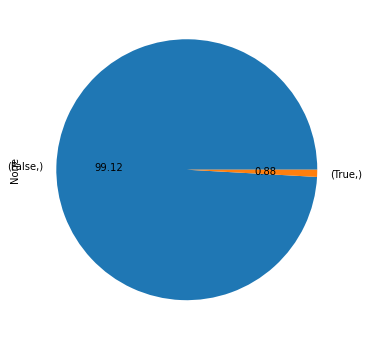

In [ ]:
y_train.value_counts().plot.pie(autopct = "%.2f", y=" ")

### Train Baseline model: Logit

The base model that we use as a benchmark to assess the approaches is a logistic regression model. The reason for choosing this as a base model is because logistic regression is a standard classifier which on its own does not tackle class imbalance. Its weaknesses were pointed out in 1.2 Challenges of class imbalance. It is interesting to see how the base model modified with regards to class imbalance and other approaches compare to the base model in terms of classification performance on the validation as well as kaggle test data.



In [ ]:
#exclude categorical (already dummy coded) and datetime variables
X_train1 = X_train_dummies.select_dtypes(exclude=["category","datetime64[ns]"])
X_train1.drop("dti", inplace=True, axis=1)

X_test1 = X_test_dummies.select_dtypes(exclude=["category","datetime64[ns]"])
X_test1.drop("dti", inplace=True, axis=1)

X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 91697 to 10750
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fico                   119988 non-null  float64
 1   mi_pct                 119988 non-null  int64  
 2   cnt_units              119988 non-null  int64  
 3   cltv                   119988 non-null  float64
 4   orig_upb               119988 non-null  int64  
 5   ltv                    119988 non-null  float64
 6   int_rt                 119988 non-null  float64
 7   orig_loan_term         119988 non-null  int64  
 8   flag_fthb_N            119988 non-null  uint8  
 9   flag_fthb_Y            119988 non-null  uint8  
 10  occpy_sts_P            119988 non-null  uint8  
 11  occpy_sts_S            119988 non-null  uint8  
 12  channel_C              119988 non-null  uint8  
 13  channel_R              119988 non-null  uint8  
 14  loan_purpose_N         119988 non

In [ ]:
X_test1.info()
x_test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29997 entries, 120835 to 114765
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fico                   29997 non-null  float64
 1   mi_pct                 29997 non-null  int64  
 2   cnt_units              29997 non-null  int64  
 3   cltv                   29997 non-null  float64
 4   orig_upb               29997 non-null  int64  
 5   ltv                    29997 non-null  float64
 6   int_rt                 29997 non-null  float64
 7   orig_loan_term         29997 non-null  int64  
 8   flag_fthb_N            29997 non-null  uint8  
 9   flag_fthb_Y            29997 non-null  uint8  
 10  occpy_sts_P            29997 non-null  uint8  
 11  occpy_sts_S            29997 non-null  uint8  
 12  channel_C              29997 non-null  uint8  
 13  channel_R              29997 non-null  uint8  
 14  loan_purpose_N         29997 non-null  uint8  
 

AUC validation dataset: 0.7700317765548405
AUC training dataset: 0.7599200261328243
G-mean: 0.0
F1 score: 0.0


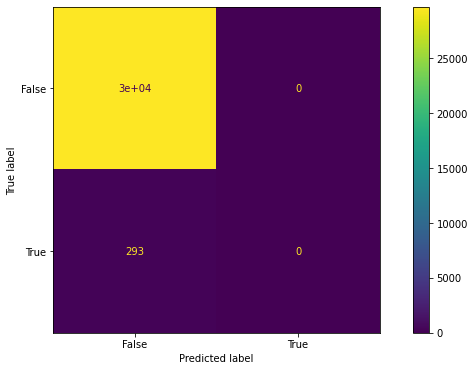

In [ ]:
from sklearn.linear_model import LogisticRegression # We will use sklearn here as it is required in the next algorithms
from sklearn.metrics import roc_auc_score
from sklearn import metrics

clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train1, np.ravel(y_train.values))
y_pred = clf.predict(X_test1)

print("AUC validation dataset:",roc_auc_score(y_test, clf.predict_proba(X_test1)[:,1]))
print("AUC training dataset:",roc_auc_score(y_train, clf.predict_proba(X_train1)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(y_test), clf.predict(X_test1)).round(3))
print('F1 score:', f1_score(y_test, clf.predict(X_test1)).round(3))
metrics.plot_confusion_matrix(clf, X_test1, np.ravel(y_test))

Our base model has moderately high auc values. However, when taking a look at Gmean and F1 score, we learn that auc does not necessarily mean it is a good model. The confusion matrix gives more insight into this. The classifier predicted none of the cases of the validation data as belonging to the positive class (minority class). This is consistent with the challenges laid out before that a standard classifier does not perform well as far as the minority class is concerned. The classifier is biased towards the majority class. This proves that it is important to add Gmean and F1 score in addition to compare and evaluate models.

In [ ]:
x_test_kaggle["flag_fthb_N"] = 0 # initiating col for no
x_test_kaggle["flag_fthb_N"] = x_test_kaggle["flag_fthb_N"].astype('uint8')

In [ ]:
x_test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50015 entries, 0 to 50014
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fico                   50015 non-null  float64
 1   mi_pct                 50015 non-null  int64  
 2   cnt_units              50015 non-null  int64  
 3   cltv                   50015 non-null  float64
 4   orig_upb               50015 non-null  int64  
 5   ltv                    50015 non-null  float64
 6   int_rt                 50015 non-null  float64
 7   orig_loan_term         50015 non-null  int64  
 8   rel_ref_ind_True       50015 non-null  uint8  
 9   flag_sc_True           50015 non-null  uint8  
 10  cnt_borr_True          50015 non-null  uint8  
 11  flag_fthb_Y            50015 non-null  uint8  
 12  occpy_sts_P            50015 non-null  uint8  
 13  occpy_sts_S            50015 non-null  uint8  
 14  channel_C              50015 non-null  uint8  
 15  ch

In [ ]:
x_test_kaggle.head()

,fico,mi_pct,cnt_units,cltv,orig_upb,ltv,int_rt,orig_loan_term,rel_ref_ind_True,flag_sc_True,...,dti_dis_four,dti_dis_not available,dti_dis_one,dti_dis_three,dti_dis_two,prop_type_CP,prop_type_MH,prop_type_PU,prop_type_SF,flag_fthb_N
0,746.0,0,1,80.0,544000,80.0,4.500,360,0,1,...,0,0,0,0,0,0,0,0,1,0
1,665.0,30,1,95.0,356000,95.0,5.250,360,0,0,...,0,0,0,0,0,0,0,0,1,0
2,765.0,0,1,75.0,71000,75.0,4.500,240,0,0,...,0,0,0,0,0,0,0,0,1,0
3,727.0,30,1,95.0,182000,95.0,4.250,360,0,0,...,1,0,0,0,0,0,0,0,1,0
4,798.0,0,1,79.0,171000,79.0,4.125,360,0,0,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
clf.fit(X_train1, np.ravel(y_train.values))
y_pred_kaggle = clf.predict_proba(x_test_kaggle)
y_pred_kaggle[:,1] # create predictions for kaggle

array([0.00477837, 0.01777503, 0.00387714, ..., 0.00151722, 0.00356735,
       0.00420153])

In [ ]:
from google.colab import files
pd.DataFrame(y_pred_kaggle).to_csv('output.csv', encoding = 'utf-8-sig')
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3.2.1. Preprocessing approach

Preprocessing approaches can be divided into:


*   resampling techniques

and
*   feature selection

**Resampling techniques**

Resampling techniques tackle the imbalance by rebalancing the data. The data is preprocessed and converted into a balanced dataset by removing data points belonging to the majority class or creating new data points belonging to the minority class. The objective is to have a rather instances of each class to handle the biasedness towards the majority class and also handle the disjuncts problem.

**Feature Selection**

Feature Selection aims at selecting a subset of features, i.e. removing redundant and irrelevant features from the feature space to optimize the decision boundary (e.g. to deal with class overlap) and therefore the performance of the classifier.






In this part, we apply different pre-processing approaches to enhance our LR base model. The objective is to see how the approaches, stand-alone or also combined, improve the performance of our standard classifier.

### a Resampling
Regarding resampling techniques, [6] provides an overview and comparison of common resampling techniques(oversampling, undersampling and hybrid) applied on synthetic data.



#### Oversampling: SMOTE



SMOTE (Synthetic Minority Over-sampling Technique) adds new examples to minority class by computing a probability distribution to model the smaller class, thus making the decision boundary larger in order to capture adjacent minority class examples

In [ ]:
#SMOTE BASIC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
import warnings

#Resampling
X_resampled, y_resampled = SMOTE(sampling_strategy = 1.0, random_state=888).fit_resample(X_train1, np.ravel(y_train))
# try with sampling_strategy=0.01

#Model
clf = LogisticRegression(max_iter=200, random_state=888, fit_intercept=True).fit(X_resampled, np.ravel(y_resampled))

#Performance

print("AUC training dataset:",roc_auc_score(y_resampled, clf.predict_proba(X_resampled)[:,1]).round(3))
print('\nPerformance on validation data:')
print("AUC:",roc_auc_score(y_test, clf.predict_proba(X_test1)[:,1]).round(3))
print("G-mean:", geometric_mean_score(np.ravel(y_test), clf.predict(X_test1)).round(3))
print('F1 score:', f1_score(y_test, clf.predict(X_test1)).round(3))
cmat_smote =metrics.confusion_matrix(y_test, np.where(clf.predict_proba(X_test1)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = clf.predict_proba(x_test_kaggle)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
#files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

AUC training dataset: 0.752

Performance on validation data:
AUC: 0.772
G-mean: 0.709
F1 score: 0.043


**Borderline SMOTE 1 & 2:**

Borderline SMOTE is a variation of SMOTE.

SMOTE 1: For each point in minority class:

1. Compute its m nearest neighbors in training set. Call this set
$M_p$ and let $m' = |M_p \cap L|$
2. If $m' = m$ then point is a noisy example. Ignore p and con-
tinue to the next point.
3. If $0 <= m' <= m/2$  , point is safe. Ignore p and continue to
the next point.
4. If m/2 ≤ m’ ≤ m, add point to the set DANGER. For each point d in DANGER, apply the SMOTE algorithm to generate synthetic examples.

Borderline-SMOTE2 is similar to Borderline-SMOTE1 ex-
cept in the last step, new synthetic examples are created
along the line joining points in DANGER to either their
nearest neighbors in S or their nearest neighbors in L.

We also applied Borderline SMOTE in addition to SMOTE. However, results were not significantly different and are therefore not shown below.

#### Undersampling

**Undersampling** resample majority class using vector quantization to construct representative local models to train logit-based models. The most common undersampling algorithms are:

##### **Random Undersampling**

Random undersampling of majority class (+) simple (-) loss of information at the end fewer obs for maj classs

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# resample X, y train
model = RandomUnderSampler(sampling_strategy=0.88, random_state=888)
X_resampled, y_resampled = model.fit_resample(X_train1, np.ravel(y_train))

# fit baseline model with resampled data
logit = LogisticRegression(random_state=888, max_iter=200)
logit.fit(X_resampled, y_resampled)

#Performance

print("AUC training dataset:",roc_auc_score(y_resampled, logit.predict_proba(X_resampled)[:,1]).round(3))
print('\nPerformance on validation data:')
print("AUC:",roc_auc_score(y_test, logit.predict_proba(X_test1)[:,1]).round(3))
print("G-mean:", geometric_mean_score(np.ravel(y_test), logit.predict(X_test1)).round(3))
print('F1 score:', f1_score(y_test, logit.predict(X_test1)).round(3))
cmat_rus =metrics.confusion_matrix(y_test, np.where(logit.predict_proba(X_test1)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = logit.predict_proba(x_test_kaggle)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
#files.download('pred_kaggle.csv')

AUC training dataset: 0.739

Performance on validation data:
AUC: 0.772
G-mean: 0.711
F1 score: 0.047


Further undersampling techniques are as follows:

**NearMiss**-[1, 2, 3]: NearMiss 1 is undersampling of points in the majority class based on their distance to other points in the same class. points from majority retained whose mean distance to the k nearest points in minority is lowest, where k is a tunable hyperparameter.
<br>NearMiss-2 keeps those points from majority class whose mean distance to the k farthest points in minority class is lowest.
<br>NearMiss-3 selects k nearest neighbors in majority class for every point in minority class

**CNN**choose subset of the training set such that for every point in training set its nearest neighbor in subset is of the same class. Subset can be grown iteratively. (-) can be slower.

**ENN** Edited Nearest Neighbor undersampling of the majority class is done by removing points whose class label differs from a majority of its k nearest neighbors

**Repeated Edited Nearest Neighbor**ENN algorithm is applied successively until ENN can remove no further points

**Tomek Link Removal** pair of examples is called a Tomek link if they belong to different classes and are each other's nearest neighbors. Undersampling can be done by removing all tomek links from the dataset.

We will be applying some of the aforementioned techniques on the test data.

#### Hybrid
We will be testing combinations of over- and undersampling to see the results. Specifically, SMOTE combined with ENN:

##### SMOTEENN


In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

model = SMOTEENN(random_state=88, sampling_strategy=1.0)
X_resampled, y_resampled = model.fit_resample(X_train1, np.ravel(y_train))

# fit baseline model with resampled data
logit = LogisticRegression(max_iter=200, random_state=888)
logit.fit(X_resampled, y_resampled)

print("AUC training dataset:",roc_auc_score(y_resampled, logit.predict_proba(X_resampled)[:,1]).round(3))
print('\nPerformance on validation data:')
print("AUC:",roc_auc_score(y_test, logit.predict_proba(X_test1)[:,1]).round(3))
print("G-mean:", geometric_mean_score(np.ravel(y_test), logit.predict(X_test1)).round(3))
print('F1 score:', f1_score(y_test, logit.predict(X_test1)).round(3))
cmat_smoteenn =metrics.confusion_matrix(y_test, np.where(logit.predict_proba(X_test1)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = logit.predict_proba(x_test_kaggle)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
# files.download('pred_kaggle.csv')

AUC training dataset: 0.784

Performance on validation data:
AUC: 0.767
G-mean: 0.696
F1 score: 0.04


#### Results and Discussion: Resampling Methods

| Model | AUC Train | AUC Validation | Gmean Validation | F1 Validation | AUC Kaggle | Imbalance ratio after resampling |   
|---|---|---|---|---|---|---|
|Logistic regression|0.760|0.770|0.000|0.000| 0.655|n/a|
|SMOTE|0.752|0.772|0.709|0.043|0.628|1.0|
|Random Undersampling|0.739|0.772|0.711|0.047|0.623|0.88|
|SMOTE+ENN| 0.784| 0.767|0.696 | 0.040| 0.630|1.0|
Table 1: Resampling approaches results

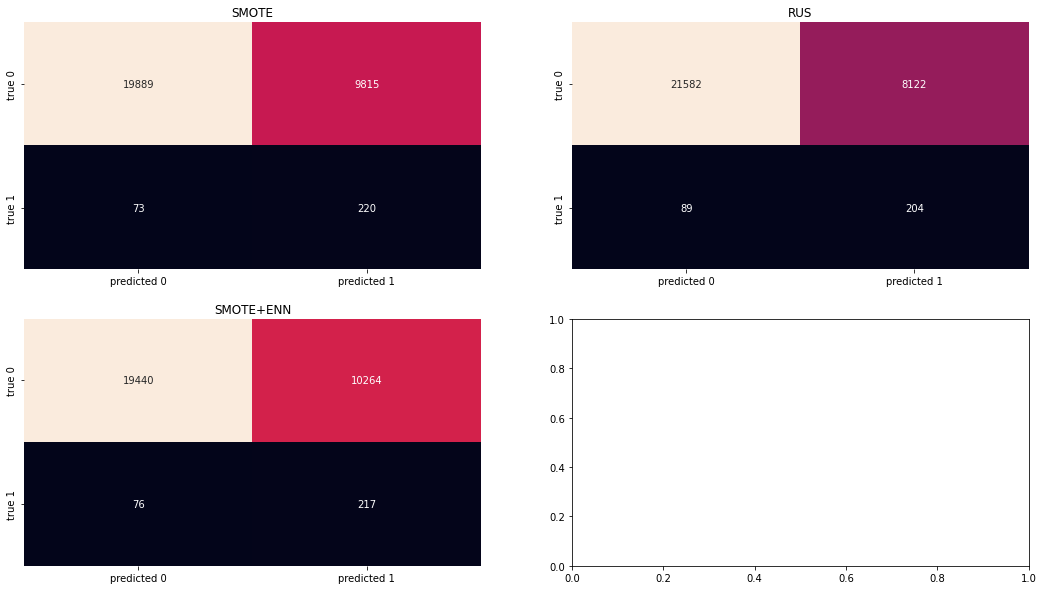

In [ ]:
# Plot Confusion Matrix using Heatmap
plt.rcParams['figure.figsize'] = (18
, 10)

import seaborn as sns
fig, ax_lst = plt.subplots(2, 2)
cmat_list = [cmat_smote, cmat_rus, cmat_smoteenn]
csm_types = ["SMOTE", "RUS","SMOTE+ENN"] # types of resampling

for i, j, ax in zip(cmat_list, csm_types, ax_lst.flat):

    # Plot heatmap
    ax.set_title(j)
    sns.heatmap(i, ax=ax, annot=True, fmt='g', cbar=False, xticklabels=['predicted 0', 'predicted 1'], yticklabels=['true 0', 'true 1'])

plt.show()

Table 1 shows the performance of our resampling approaches. Although the AUC on resampled training data is not ideal, the models trained from the resampled data fit better to the validation data and new dataset from kaggle compared to their fit to the training data (data after resampling). This is because SMOTE will be applied to the new data instead of resampled new data.

Although there are no significant differences in AUC validation and AUC kaggle, it is important to note that the Gmean and F1 score have improved significantly when resampling was conducted before the base learner was trained. This proves the purpose of resampling of balancing out the giving higher recognition to the minority class. While the base learner on its own had zero true positives, instead misclassifying all positive instances, the base learner trained on the resampled data misclassyfied 25-30% of the real positive instances from the validation set which shows a major improvement. As the objective when dealing with class imbalance is to minimize error cost and our false negatives, it is one step closer to achieving what we desire. Therefore, considering our objective the resampling methods combined with the logistic regression outperform the base learner although the base learner yields the highest AUC on kaggle data.

Taking a closer look on each resampling technique, SMOTE shows the least number of false negatives. However the The performance of the logistic regression estimator has improved slightly after performing random undersampling. This is possibly due to not sufficient amounts of 'noise' being removed from the majority class. Due to the highly imbalanced data (~0.92% of observations belong to minority class) it would not be expected a simple technique like this wouldy yield significant improvements. Nevertheless, random undersampling does a decent job predicting the minority class, which is also observed from the F-score.

Lastly, looking at the hybrid combination of SMOTE+ENN we see that even though after this resampling technique logistic regression can predict the minority class the best, it also predicts the majority class the worst, which is also seen by the lowest F-score. For this reason it performs overall not best even though it combines two different approaches.

We will proceed with random undersampling for hybrid models later in this subsection as it is scoring the highest Gmean and AUC on validation data. RUS has the best balanced performance on minority and majority class.

### b Feature selection

**Feature selection**

Extant literature names feature selection as an approach to handle imbalanced data, especially when there is simultaneously high dimensionality existent [1-3]. However there are few studies that propose feature selection methods specifically with regards to class imbalance. Authors from [13] introduce a method where the majority class is partitioned into smaller pseudo-subclasses. Subsequently, feature selection is done on the the decompsed data. Their second approach is a Hellinger distance-based method. Their results show that their two approaches can outperform existing feature-selection methods on imbalanced data. Similar to this study, other works propose feature selection approaches with high-dimensional data. Due to the restrictions of implementation (code-wise) of proposed approaches and low dimensionality of our credit risk dataset we opt for traditional methods of feature selection.

Feature selection methods are divided into filters, wrappers and embedded methods [14]. The goal of feature selection is to find a subset of features, i.e. removing redundant and irrelevant features from the feature space, to optimize the decision boundary (e.g. to deal with class overlap) and therefore the performance of the classifier.

While filter methods use statistical measures e.g. correlation to choose features, wrapper methods are based on a specific learning algorithm. Wrapper methods incrementally add or remove features to find the most relevant ones, i.e. features with the most predictive and discriminative power. Embedded methods combine the prior two methods and implement feature selection in the model building process.

We apply wrappers as they yield better results than filter methods, although computionally costly. However, we do not face constraints with regards to computing time. We want to find an optimal subset of features which can then be combined with the other approaches.

In [ ]:
%pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.9 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


####Forward Selection

Forward feature selection methods start with an empty set of features and incrementally add features in each learning iteration of the algorithm to find features with the most predictive power. We choose scoring to be roc_auc as the flaws of accuracy have been pointed out.

In [ ]:
#train and fit, roc_auc scoring
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

clf = LogisticRegression(random_state=888, max_iter=1000, tol=0.01)
sfs = SFS(clf,
           k_features=(6,20),
           forward=True,
           floating=False,
           scoring='roc_auc',
           cv=5)

sfs = sfs.fit(X_train1, np.ravel(y_train.values))

In [ ]:
print('The best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))
#same result as accuracy scoring

In [ ]:
#adjusting training, validation and kaggle data to include only variables selected from forwards selection
X_train_sfs = X_train1[['fico', 'mi_pct', 'cltv', 'int_rt', 'orig_loan_term', 'occpy_sts_P', 'occpy_sts_S', 'channel_C', 'loan_purpose_N', 'loan_purpose_P', 'pgrm_ind2_H', 'dti_dis_four', 'dti_dis_one', 'dti_dis_three', 'dti_dis_two', 'prop_type_CP', 'prop_type_PU', 'prop_type_SF', 'cnt_borr_True', 'rel_ref_ind_True']]
X_train_sfs
X_test_sfs = X_test1[['fico', 'mi_pct', 'cltv', 'int_rt', 'orig_loan_term', 'occpy_sts_P', 'occpy_sts_S', 'channel_C', 'loan_purpose_N', 'loan_purpose_P', 'pgrm_ind2_H', 'dti_dis_four', 'dti_dis_one', 'dti_dis_three', 'dti_dis_two', 'prop_type_CP', 'prop_type_PU', 'prop_type_SF', 'cnt_borr_True', 'rel_ref_ind_True']]
x_test_sfs = x_test_kaggle[['fico', 'mi_pct', 'cltv', 'int_rt', 'orig_loan_term', 'occpy_sts_P', 'occpy_sts_S', 'channel_C', 'loan_purpose_N', 'loan_purpose_P', 'pgrm_ind2_H', 'dti_dis_four', 'dti_dis_one', 'dti_dis_three', 'dti_dis_two', 'prop_type_CP', 'prop_type_PU', 'prop_type_SF', 'cnt_borr_True', 'rel_ref_ind_True']]

In [ ]:
X_train_sfs.info()

In [ ]:
#Base Model with selected features from Sequential Forward Selector
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train_sfs, np.ravel(y_train.values))
y_pred = clf.predict(X_test_sfs)


#Performance
print("AUC training dataset:",roc_auc_score(y_train, clf.predict_proba(X_train_sfs)[:,1]).round(3))
print('\nPerformance on validation data:')
print("AUC:",roc_auc_score(y_test, clf.predict_proba(X_test_sfs)[:,1]).round(3))
print("G-mean:", geometric_mean_score(np.ravel(y_test), clf.predict(X_test_sfs)).round(3))
print('F1 score:', f1_score(y_test, clf.predict(X_test_sfs)).round(3))
cmat_sfs =metrics.confusion_matrix(y_test, np.where(clf.predict_proba(X_test_sfs)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = clf.predict_proba(x_test_sfs)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
#files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

####Backward Elimination

Backward elimination methods start with the full set of features and incrementally remove features in each learning iteration of the algorithm to find features with the most predictive power. We choose scoring to be roc_auc as the flaws of accuracy have been pointed out.

In [ ]:
from sklearn.feature_selection import RFECV
clf = LogisticRegression(random_state=888, max_iter=10000, tol=0.001)

rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='roc_auc')
X_train_backward = rfecv.fit(X_train1,  np.ravel(y_train.values))

print('Optimal number of features: {}'.format(rfecv.n_features_))

In [ ]:
X_train1.columns[rfecv.support_]

In [ ]:
#adjusting training and validation data to include only variables selected from backward elimination
X_train_backward = X_train1[['fico', 'mi_pct', 'cnt_units', 'cltv', 'orig_upb', 'ltv', 'int_rt',
       'orig_loan_term', 'flag_fthb_N', 'flag_fthb_Y', 'occpy_sts_P',
       'occpy_sts_S', 'channel_C', 'channel_R', 'loan_purpose_N',
       'loan_purpose_P', 'pgrm_ind2_nine', 'dti_dis_four',
       'dti_dis_not available', 'dti_dis_three', 'dti_dis_two', 'prop_type_PU',
       'prop_type_SF', 'cnt_borr_True', 'rel_ref_ind_True']]
X_test_backward = X_test1[['fico', 'mi_pct', 'cnt_units', 'cltv', 'orig_upb', 'ltv', 'int_rt',
       'orig_loan_term', 'flag_fthb_N', 'flag_fthb_Y', 'occpy_sts_P',
       'occpy_sts_S', 'channel_C', 'channel_R', 'loan_purpose_N',
       'loan_purpose_P', 'pgrm_ind2_nine', 'dti_dis_four',
       'dti_dis_not available', 'dti_dis_three', 'dti_dis_two', 'prop_type_PU',
       'prop_type_SF', 'cnt_borr_True', 'rel_ref_ind_True']]

In [ ]:
x_test_kaggle.info()

In [ ]:
#adjusting kaggle data to include only variables selected from backward elimination
x_test_backward = x_test_kaggle[['fico', 'mi_pct', 'cnt_units', 'cltv', 'orig_upb', 'ltv', 'int_rt',
       'orig_loan_term', 'flag_fthb_N', 'flag_fthb_Y', 'occpy_sts_P',
       'occpy_sts_S', 'channel_C', 'channel_R', 'loan_purpose_N',
       'loan_purpose_P', 'pgrm_ind2_nine', 'dti_dis_four',
       'dti_dis_not available', 'dti_dis_three', 'dti_dis_two', 'prop_type_PU',
       'prop_type_SF', 'cnt_borr_True', 'rel_ref_ind_True']]

In [ ]:
#Base Model with selected features from Backward Elimination
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train_backward, np.ravel(y_train.values))
y_pred = clf.predict(X_test_backward)

#Performance
print("AUC training dataset:",roc_auc_score(y_train, clf.predict_proba(X_train_backward)[:,1]).round(3))
print('\nPerformance on validation data:')
print("AUC:",roc_auc_score(y_test, clf.predict_proba(X_test_backward)[:,1]).round(3))
print("G-mean:", geometric_mean_score(np.ravel(y_test), clf.predict(X_test_backward)).round(3))
print('F1 score:', f1_score(y_test, clf.predict(X_test_backward)).round(3))
cmat_backward =metrics.confusion_matrix(y_test, np.where(clf.predict_proba(X_test_backward)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = clf.predict_proba(x_test_backward)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
#files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

As the performance of the model with features selected from forward selection is better, we proceed with a dataset including variables selected from **forward selection** for hybrid combinations. We note that the Gmean and F1 score are zero which means that either specificity or sensitivity is zero, implying zero true negatives. Given that the positives are the minority, it is likely that there are no true positives. The confusion matrix which we show to summarize the results for this part should give more insight.

####Hybrid

We combine feature selection with a selected number of resampling techniques.

#### Forward Feature Selection+SMOTE



In [ ]:
#Smote with selected features from forward selection
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
import warnings

X_resampled, y_resampled = SMOTE(random_state=888, sampling_strategy=1).fit_resample(X_train_sfs, np.ravel(y_train))

clf = LogisticRegression(max_iter=200, random_state=888, fit_intercept=True).fit(X_resampled, np.ravel(y_resampled))

#Performance
print("AUC training dataset:",roc_auc_score(y_resampled, clf.predict_proba(X_resampled)[:,1]).round(3))
print('\nPerformance on validation data:')
print("AUC:",roc_auc_score(y_test, clf.predict_proba(X_test_sfs)[:,1]).round(3))
print("G-mean:", geometric_mean_score(np.ravel(y_test), clf.predict(X_test_sfs)).round(3))
print('F1 score:', f1_score(y_test, clf.predict(X_test_sfs)).round(3))
cmat_sfs_smote =metrics.confusion_matrix(y_test, np.where(clf.predict_proba(X_test_sfs)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = clf.predict_proba(x_test_sfs)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
#files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Forward Feature Selection+Random Under Sampling(RUS)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# resample X, y train
X_resampled, y_resampled = RandomUnderSampler(random_state=888, sampling_strategy=0.88).fit_resample(X_train_sfs, np.ravel(y_train))


clf = LogisticRegression(max_iter=200, random_state=888, fit_intercept=True).fit(X_resampled, np.ravel(y_resampled))
y_pred = clf.predict(X_test_sfs)


#Performance
print("AUC training dataset:",roc_auc_score(y_resampled, clf.predict_proba(X_resampled)[:,1]).round(3))
print('\nPerformance on validation data:')
print("AUC:",roc_auc_score(y_test, clf.predict_proba(X_test_sfs)[:,1]).round(3))
print("G-mean:", geometric_mean_score(np.ravel(y_test), clf.predict(X_test_sfs)).round(3))
print('F1 score:', f1_score(y_test, clf.predict(X_test_sfs)).round(3))
cmat_sfs_rus =metrics.confusion_matrix(y_test, np.where(clf.predict_proba(X_test_sfs)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = clf.predict_proba(x_test_sfs)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
#files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

####Results and Discussion: Pre-processing methods


| Model | AUC Train | AUC Validation | Gmean Validation | F1 Validation | AUC Kaggle |  
|---|---|---|---|---|---|
|Logistic regression|0.760|0.770|0.000|0.000| 0.655|
|Forward Selection|0.824|0.824|0.058|0.007|0.730|
|Backward Elimination|0.760|0.770|0.000|0.000|0.655|
|Forward Selection + SMOTE|0.924|0.732|0.634|0.052|0.640|
|Forward Selection + RUS|0.820|0.825|0.753|0.058|0.714|

Table 2: Pre-processing approaches results

In [ ]:
# Plot Confusion Matrix using Heatmap
plt.rcParams['figure.figsize'] = (18
, 10)

import seaborn as sns
fig, ax_lst = plt.subplots(2, 2)
cmat_list = [cmat_sfs, cmat_backward, cmat_sfs_smote, cmat_sfs_rus]
csm_types = ["Forward Selection", "Backward Elimination", "Forward Selection + SMOTE","Forward Selection + RUS"]

for i, j, ax in zip(cmat_list, csm_types, ax_lst.flat):

    # Plot heatmap
    ax.set_title(j)
    sns.heatmap(i, ax=ax, annot=True, fmt='g', cbar=False, xticklabels=['predicted 0', 'predicted 1'], yticklabels=['true 0', 'true 1'])

plt.show()

As mentioned, in the preprocessing part all methods are combined with a logistic regression base model in order to compare them to our benchmark logistic regression base model and see if these methods prove helpful to deal with the challenges in imbalanced learning. Now, we compare the models along the dimensions of the performance measure from table 2. It is evident that in terms of feature selection the forward selection outperforms base learner model as opposed to the backward elimination which has the exact same performance as the base model. This implies that the backward elimination failed to extract discriminative features, therefore leading to a performance mirroring that of the base model.

However, although forward selection on its own may yield high AUC values, it is important to note that the Gmean and F1 score are very low. As mentioned before, a low Gmean implies a poor performance of the classifier on either minority or majority class.Taking a look at the confusion matrix, we can point it to a low sensitivity, i.e. a low recognition of the minority class. Out of 293 positive instances in the validation data, only one was correctly predicted.

We learn that traditional feature selection methods on its own can not be used to handle class imbalance. The combination of forward selection with random undersampling is better compared to the combintation of forward selection with SMOTE in terms of all performance measures in table 2 except for AUC train. This is also reflected in the confusion matrices. THe combination of forward selection and random undersampling also has a higher scores across all performance measures when we compare table 2 and table 1. In addition to that, when comparing this combination to random undersampling used on its own, while both classify the same number of positive instances correctly, the combination even classifies more negative instances correctly (more true negatives), i.e. has a better performance on the negative class. Applied to real context, the bank would not miss out as much on good opportunities.

Feature selection finds a subset from the feature space to optimize the decision boundary. When imbalance exists in the dataset, their combination seems to first tackle challenges of disjuncts and class overlap and additionally bias towards majority class.

For this part, it can be concluded that forward selection combined with random undersampling yields the best result. Although it does not give the highest AUC kaggle, it gives the highest AUC validation and the highest Gmean. The latter is especially important because it indicates that there is a good performance on the minorty class. As additionally the performance on the majority class is even better compared to the other methods, this combination might lead to lowest misclassification cost.  



---



## 3.2.2. Algorithm approach




Algorithm-level solutions can be viewed as an alternative or complementary approach to pre-processing methods for handling imbalanced datasets. In general, this approach focus on adapting the classifier learning process by modifying the cost per class or adjusting the probability estimation in the leaves of a decision tree to favor
the minority class, without shifting the data distribution. It can be categorised into ensemble learning and cost-sensitive learning. The following subsections will discuss each category in details.

### a.Ensemble learning

The ensemble learning is a multi-step modeling approach with the aim of raising the predictive accuracy of the model by combining sereval base classifiers. This process trains the dataset with multiple base models and aggregate their predictions to improve the performance of the model in terms of its predictive power. Different base models learn different patterns from the same training set and can thereby complement each other. In addition, ensemble learning is advantageous in the scenario of bias-variance tradeoff.

* Model with High complexity
   * Low bias
   * High Variance
* Model with low complexity
   * High bias
   * Low Variance
* Ensemble learning
   * Model combination reduces variance
   * Combination may also reduce bias


Based on how the classifiers been ensembeld, one flavour is bagging style approach, which generate base learners in parallel, another one is boosting which generate base learners in sequential, which means that a former base learner has influence on the subsequent learners.


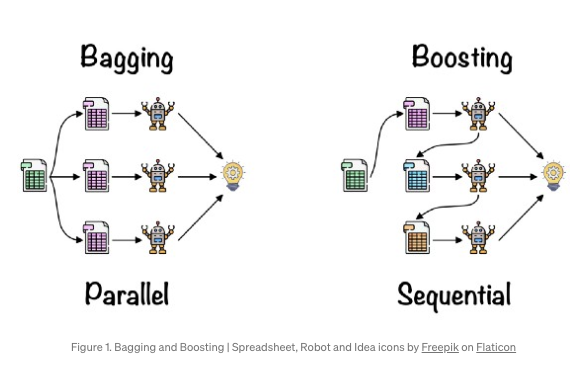

reference:https://towardsdatascience.com/ensemble-learning-bagging-boosting-3098079e5422

The ensemble methods for class imbalance learning intergrate the preprocessing approach and also cost sensitive learning in order to improve the performance. It can be generally categorised into 4 flavours as below.[8,9]




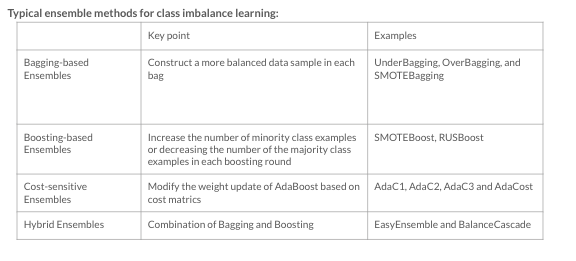


1.   In first flavour, bagging-based ensemble method incorporate preprocessing approach in each bag by random drawn sample with replacement.
2.  In the second flavour, boosting-based ensemble also incorporates preprocessing approach, trying to construct a balanced data in each boosting round.
3.   The third flavour is cost-sensitive ensemble, which basically modify the weight of samples based on cost metrics.
4.  The last one is called hybrid ensembles, which is a combination of bagging and boosting style ensemble.








Following shows the models which outperform the base model on either validation data or the kaggle new data. We use decision tree as base learner and then use grid search for hyperparameter tuning among number of estimators with 30 or 50, in order to achieve a ideal result and also make the result comparable. The code and description of each method is also shown below.

####Adaboost

The basic idea of Adaboost is to reweight the falsely classified examples in each iteration round and train the next classifer based on the reweighted training data. We use grid search for hyperparameter tuning and then train the Adaboost classifier based on the tuning result as following. The steps are as follow:


*   Step 1: train the first weak classifier
*   Step 2: reweight examples based on error
*   Step 3: in each iteration round, train classifier and reweight examples
*   Final step: weighted average over base model predictions









In [ ]:
#grid search for hyperparameter tuning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
abc =AdaBoostClassifier()

param_grid = {'n_estimators': [30,50],
              'learning_rate' : [0.05,0.02]
             }

search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_train1, y_train)
search.best_params_
#{'learning_rate': 0.05, 'n_estimators': 50}

In [ ]:
abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=50, random_state=0)
abc.fit(X_train1, y_train)
print("AUC validation dataset:",roc_auc_score(y_test, abc.predict_proba(X_test1)[:,1]))
print("AUC training dataset:",roc_auc_score(y_train, abc.predict_proba(X_train1)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(y_test), abc.predict(X_test1)).round(3))
print('F1 score:', f1_score(y_test, abc.predict(X_test1)).round(3))
cmat_adaboost =metrics.confusion_matrix(y_test, np.where(abc.predict_proba(X_test1)[:, 1] >=  0.5, 1, 0))
# make predictions for kaggle data
y_pred_kaggle = abc.predict_proba(x_test_kaggle)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Xgb

In Xgb, a base learner is fitted to the negative gradient of the loss w.r.t. the model predictions and  the model is updated in a greedy, gradient-descent style manner. We use grid search for hyperparameter tuning and then train the Xgb classifier based on the tuning result as following.

Gradient Boosting = Gradient Descent + Boosting

* "Fit an additive model(ensemble) in a forward stage-wise manner"

* In each iteration, a weak classifier is introduced to make-up for the shortcomings of previous weak classifiers, i.e to cover the discrepency between target function and the current ensemble prediction.

*  In Gradient Boosting,"shortcomings" are identified by Gradient descent





reference: http://www.chengli.io/tutorials/gradient_boosting.pdf

In [ ]:
#grid search for hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from xgboost import XGBClassifier

xgb= XGBClassifier()

params = {'learning_rate': [0.05,0.08],
        'max_depth': [20,15],
        'colsample_bytree': [0.8,0.5],
        'n_estimators':[50,30]}

search = HalvingGridSearchCV(estimator = xgb, param_grid=params,
                         random_state=0,cv=5, scoring='roc_auc').fit(X_train1, y_train)

search.best_params_
#{'colsample_bytree': 0.5,
# 'learning_rate': 0.05,
# 'max_depth': 15,
# 'n_estimators': 50}

In [ ]:
from xgboost import XGBClassifier #train xgb
xgb = XGBClassifier(
    max_depth=15, n_estimators=50, learning_rate=0.05,colsample_bytree=0.5,random_state= 888)
xgb.fit(X_train1, y_train)
print(roc_auc_score(y_test, xgb.predict_proba(X_test1)[:,1]))
print(roc_auc_score(y_train, xgb.predict_proba(X_train1)[:,1]))
print("AUC validation dataset:",roc_auc_score(y_test, xgb.predict_proba(X_test1)[:,1]))
print("AUC training dataset:",roc_auc_score(y_train, xgb.predict_proba(X_train1)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(y_test), xgb.predict(X_test1)).round(3))
print('F1 score:', f1_score(y_test, xgb.predict(X_test1)).round(3))
cmat_xgb =metrics.confusion_matrix(y_test, np.where(xgb.predict_proba(X_test1)[:, 1] >=  0.5, 1, 0))
# make predictions for kaggle data
x_test_kaggle = x_test_kaggle[X_train1.columns]
y_pred_kaggle = xgb.predict_proba(x_test_kaggle)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

####Rusboost

Rusboost adopts Adaboost architecture and also incorporates random under-sampling to remove the majority class examples in each boosting round. We use grid search for hyperparameter tuning and then train the Rusboost based on the tuning result as following.





In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.ensemble import RUSBoostClassifier
rusb =RUSBoostClassifier()

param_grid = {'n_estimators': [30,50],
              'learning_rate': [0.05,0.1]
             }

search = HalvingGridSearchCV(rusb, param_grid,
                            random_state=0).fit(X_train1, y_train)
search.best_params_
#'learning_rate': 0.1, 'n_estimators': 50

In [ ]:
rusb = RUSBoostClassifier(random_state=0,learning_rate = 0.1, n_estimators=50)
rusb.fit(X_train1, y_train)

print("AUC validation dataset:",roc_auc_score(y_test, rusb.predict_proba(X_test1)[:,1]))
print("AUC training dataset:",roc_auc_score(y_train, rusb.predict_proba(X_train1)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(y_test), rusb.predict(X_test1)).round(3))
print('F1 score:', f1_score(y_test, rusb.predict(X_test1)).round(3))
cmat_rusb =metrics.confusion_matrix(y_test, np.where(rusb.predict_proba(X_test1)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = rusb.predict_proba(x_test_kaggle)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Easyensemble

In Easyensemble, first it generates a set of balanced data samples in each bag, containing all minority class examples and a subset of the majority class examples and then an AdaBoost ensemble is trained from each bag. The advantage of Easyensemble is that it can keep the benefit from under-sample without ignoring the useful information contained in the majority class.


* Step 1: generate training subsets from negative subet(minority classes) using under-sampling strategy
* Step 2: Build a classfier for each subset
* Step 3: All generated classifiers are then combined for the final decision using Adaboost





In [ ]:
%pip install scikit-learn==1.0 -U
#have to downgrade the scikit-learn package using easyensemble, otherwise it throws error
#https://github.com/scikit-learn-contrib/imbalanced-learn/issues/872

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=42, n_estimators=50)
eec.fit(X_train1, y_train)

print(roc_auc_score(y_test, eec.predict_proba(X_test1)[:,1]))
print(roc_auc_score(y_train, eec.predict_proba(X_train1)[:,1]))
print("AUC validation dataset:",roc_auc_score(y_test, eec.predict_proba(X_test1)[:,1]))
print("AUC training dataset:",roc_auc_score(y_train, eec.predict_proba(X_train1)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(y_test), eec.predict(X_test1)).round(3))
print('F1 score:', f1_score(y_test, eec.predict(X_test1)).round(3))
cmat_eec =metrics.confusion_matrix(y_test, np.where(eec.predict_proba(X_test1)[:, 1] >=  0.5, 1, 0))

# make predictions for kaggle data
y_pred_kaggle = eec.predict_proba(x_test_kaggle)[:, 1] # select only column with probs for True
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

####Results and Discussion: Ensemble methods

| Model | AUC Train | AUC Validation | Gmean Validation | F1 Validation | AUC Kaggle |  
|---|---|---|---|---|---|
|Logistic regression|0.760|0.770|0.000|0.000| 0.655|
|Adaboost|0.809|0.804|0.0|0.0|0.697|
|Xgb|0.881|0.815|0.0|0.0|0.715|
|Rusboost|0.820|0.818|0.743|0.052|0.717|
|Easyensemble|0.835|0.818|0.746|0.053|0.614|

Table 3: Ensemble methods approaches results

In [ ]:
# Plot Confusion Matrix using Heatmap
plt.rcParams['figure.figsize'] = (18
, 10)

import seaborn as sns
fig, ax_lst = plt.subplots(2, 2)
cmat_list = [cmat_adaboost, cmat_xgb, cmat_rusb, cmat_eec]
csm_types = ["Adaboost", "Xgb", "Rusboost","Easyensemble"] # types of cost-sensitive methods

for i, j, ax in zip(cmat_list, csm_types, ax_lst.flat):

    # Plot heatmap
    ax.set_title(j)
    sns.heatmap(i, ax=ax, annot=True, fmt='g', cbar=False, xticklabels=['predicted 0', 'predicted 1'], yticklabels=['true 0', 'true 1'])

plt.show()

From the table, we can see that the Rusboost performs the best as to the AUC of validation data and also kaggle data. In addition, Rusboost avoids overfit the best, because it have the most balanced AUC among these three datasets. Furthermore, the confusion matrix corresponds well with the F-measure and G-mean in the table.
It can be observed that Adaboost and XGB classify all data points in "negative" class,i.e. the non-fraudulent class, which is the majority class in our case. This can be seen from F-measure,g-mean and the confusion matrix. However, they are good on the validation and new data with respect to AUC, because they classify the majority class correctly. These methods do not satisy our goal to correctly classify the rare class, hence they would not be included in the further analysis procedure.  
Looking at Rusboost and Easyensemble, they both correctly classify the most of the rare cases. Because Rusboost and Easyensemble incorporate the preprocessing techniques, they classify more examples to be the minority class compared to Adaboost and Xgb from confusion metrics. They classified around 200 cases to be bad although they have more false positive examples. Additionally, Easyensemble even though performing good on validation dataset, it does not give good performance for the new dataset(kaggle). On the contrary, RUSboost performed very well on both validation and new dataset on AUC. It also has high G-mean score of 0.743. Although, the f-measure is very small, since the false postives are very large as compared to the true positives.


In conclusion, we can see a performance improvement from Rusboost and Easyensemble, which incorporates the preprocessing techniques. They are more suitable for the imbalanced data set. Going forward to the hybrid approaches, we will use RUSBoost classfier.

### b.Cost-sensitive learning

The motivation for cost-sensitive learning with respect to class imbalance is to improve the identification performance on the small class in imbalance dataset. Most of the cost-insensitive algorithms treat the misclassified instances the same, although they may result in different costs according to the cost matrix. Thus, Class sensitive algorithms introduces bias towards the class associated with higher identification importance(usually the rare class).

Although, the predictive accuracy measures are like AUC, G-mean and f-measure are significant for measuring predictive performance for class imbalance dataset, it is also important to measure the performance of the model based on cost minimization criteria. Therefore, we use the Expected misclassfication cost to evaluate the total misclassification cost of the prediction. The EMC is defined as follows:[10]

EMC = (Cp *fn +Cn *fp)/N

Cp denotes the cost of misclassifying a bad credit as ‘good’, Cn denotes the cost of misclassifying a good credit as ‘bad’, and N denotes the total number of instances. fn denoting the misclassification errors of bad credits as ‘good’, f p denoting the misclassification errors of good credits as ‘bad’

The cost-sensitive approach can be broadly classified into three categories, given as follows:


*   Data level approach: This is a Prior-training, pre-processing approach, where modification is performed on the data level
*   Algorithmic level approach: This is an in-training approach, that involves introducing weights into the classifiers, and adapting the learning methodology to specified weights. Thus,this methodology integrates the cost into the model building process and generates a model that minimizes the total misclassification cost
*   Output level approach: By using a cost-relevant threshold, the classification output is moved towards the costly class (which is in our case is the fraudulent individuals, i.e. the rare class)

Furthermore, the Algorithmic level cost sensitive approach can be divided into two categories:

*   Class-dependent Cost-sensitive classifiers: This category follows the assumption that the misclassification cost depends on the class and is the same among individuals belonging to that class. All misclassification errors belonging to one class,carry the same cost.
*   Example-dependent cost-sensitive classifiers: In credit risk assessment systems, the frauds with high transaction amounts will be more costly, thereby making the misclassification costs vary among samples in the dataset.



#### Cost matrix

 We implemented different cost settings on the ML techiques(in the coming section).

We referred a cost matrix by Beling et al(2005) with the misclassification cost for positive class as the maximum default rate and maximium interest rate for neegative class.[11]However, this cost setting generated poor performance for the classfiers in the up-coming sections. Therefore, we do not present the code for this cost setting in our notebook.

Furthermore, we generated plausible results from the cost matrix as shown below. The cost matrix which we are using refers to Kim et al.(2012) paper. [7] The cost benefit matrix which they introduced is as follow. And it can be transformed into the cost matrix which is a standard form for cost-sensitive learning.



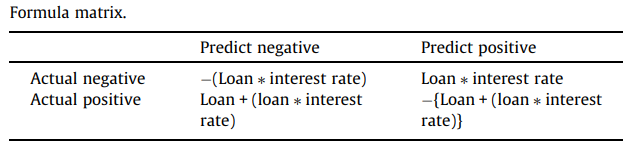

In [ ]:
#loan
loan = X_train1['orig_upb'].mean()
#interest
interest = X_train1['int_rt'].mean()/100
loaninter = loan*interest
x = loan + loaninter

In [ ]:
cost_matrix = pd.DataFrame({'actual_GOOD(0)': [0, round((loaninter+loaninter),2)],
                             'actual_BAD(1)': [round((x + x),2), 0]},
                                                     index= ['predicted_GOOD(0)', 'predicted_BAD(1)'])
cost_matrix

In [ ]:
threshold_bayes = (cost_matrix.iloc[1,0]                # C(b,G)
                   /(cost_matrix.iloc[1,0]              # C(b,G)
                     +cost_matrix.iloc[0,1])).round(5)  # C(g,B)
threshold_bayes

#### Metacost: Data-Level Approach

MetaCost changes the label of training instances to the optimal label with respect to the costs and derives the classification model using the new data set. MetaCost works as follows:


*   First step is to produce diverse bootstrap replicas of the training dataset;
*   applying a classifier to each bootstrap sample;
*   Generating the average of class probabilities that are obtained from the models  or computing the fraction of votes received from the classifiers;
*   Relabeling the samples in the training dataset using Eq. (1);
R(i|x) = \Sigma P(j|x)Cost(i,j) - Eq. (1)
*   reapplying the classifier to the relabeled training set

In our MetaCost function as seen below,for the simplification purpose we relabel the whole training dataset and do not generate multiple bootstrap samples from our training set. The classifier used for relabeling the training set is taken as Logistic Regression and the final classifier is RUSBoost.

We apply the Bayes minimal cutoff to relabel our training data. Basically, we train a model on the training set. We get the probability predictions for the test set for this model and apply the Bayes minimal cutoff to it. We use this vector as our new y_train, meaning we relabel the data using the Bayes minimal cutoff. By using this cutoff, we want to achieve cost-sensitivity. For this first step it is important to use a model that is expected to give well-calibrated predictions.

In [ ]:
# Save function to calculate error-cost
def calc_error_cost(y_probabilities, y_test, cutoff, cost_matrix):
    pred = np.where(y_probabilities >= cutoff, 1, 0)                    # convert class probabilities into class predictions
    cmat = metrics.confusion_matrix(y_test, pred)                       # compute corresponding confusion matrix
    cost = (np.sum(np.sum((cmat/len(y_test))*cost_matrix.T))).round(5)  # calculate the corresponding cost
    return [cutoff, cost]

In [ ]:
from imblearn.ensemble import RUSBoostClassifier

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
# Use model with good calibration to predict the new labels and create probability predictions
temp_pred_proba_train = LogisticRegression(random_state=0).fit(X_train1, np.ravel(y_train.values)).predict_proba(X_train1)[:,1]

  # Convert the probability predictions to class predictions using Bayes Decision Theory
temp_pred_class_train = np.where(temp_pred_proba_train >= threshold_bayes, 1, 0) # These are the new class labels

  # Fit a potent model to the test set, replacing our usual y_train with resulting class predictions from the last step
final_model = RUSBoostClassifier(random_state=0,learning_rate = 0.1, n_estimators=50)


final_model.fit(X_train1, temp_pred_class_train.ravel())

  # Get predictions for the test set
pred_proba_MC = final_model.predict_proba(X_test1)[:,1]
pred_proba_MC_train = final_model.predict_proba(X_train1)[:,1]

# Save corresponding confusion matrix for evaluation
cmat_MC = metrics.confusion_matrix(y_test, np.where(pred_proba_MC >=  0.5, 1, 0))
cmat_MC

In [ ]:
# Evaluate by calcuating the error-cost
cutoff_cost_MC = calc_error_cost(pred_proba_MC, y_test, 0.5, cost_matrix)
print("The error-cost for the MetaCost approach is: {}".format(cutoff_cost_MC[1]))
print("AUC validation dataset:",roc_auc_score(y_test, pred_proba_MC))
print("AUC training dataset:",roc_auc_score(y_train, pred_proba_MC_train))



In [ ]:
cmat_MC =metrics.confusion_matrix(y_test, np.where(pred_proba_MC >=  0.5, 1, 0))

In [ ]:
y_pred_kaggle = final_model.predict_proba(x_test_kaggle)[:, 1]
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Adacost: Class-dependent Cost sensitive classifier

In Adacost, the weight update is adjusted by a cost weighting function φ. An instance with a higher cost increases its weight more if the instance is misclassified, but decreases its weight less on the contrary. Given Ci the cost of misclassifying the ith example, the recommended function is φ+ = −0.5Ci + 0.5 and φ− = 0.5Ci + 0.5. The weight adjustment function and the computation of αt are updated by the following formulas:[9]

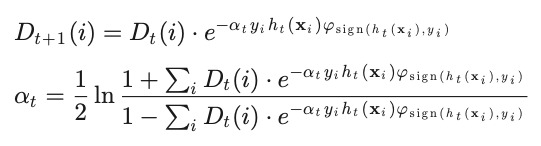

In [ ]:
pip install imbalanced-ensemble

In [ ]:
from imbalanced_ensemble.ensemble import AdaCostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
Adac = AdaCostClassifier(random_state=0)
Adac.fit(X_train1, y_train, cost_matrix = cost_matrix)

In [ ]:
print("AUC validation dataset:",roc_auc_score(y_test, Adac.predict_proba(X_test1)[:,1]))
print("AUC training dataset:",roc_auc_score(y_train, Adac.predict_proba(X_train1)[:,1]))

In [ ]:
pred_proba_Adac=Adac.fit(X_train1, y_train, cost_matrix = cost_matrix).predict_proba(X_test1)[:,1]
cmat_adac =metrics.confusion_matrix(y_test, np.where(pred_proba_Adac >=  0.5, 1, 0))

In [ ]:
cutoff_cost_adac = calc_error_cost(pred_proba_Adac, y_test, 0.5, cost_matrix)
cutoff_cost_adac[1]

In [ ]:
y_pred_kaggle = Adac.predict_proba(x_test_kaggle)[:, 1]
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Cost-relevant threshold: Output-level approach

In this approach we empirically tune the threshold to moce the output towards the costly class. This entails determining the threshold that yields the lowest misclassification cost based on the provided cost-matrix and data.This approach is similar to threshold tuning for obtaining highest accuracy score , just with a different intention. In this scenario, we want a cost-efficient cutoff rather most accurate threshold. Empirical tuning may be prone to overfitting as it bases on the same data. Therefore, cross-validation approach can be introduced and average over all cutoffs with the lowest error-cost for each fold.

##### Logistic regression threshold tuning

In [ ]:
clf = LogisticRegression(penalty='none', fit_intercept=True,random_state=0).fit(X_train1, np.ravel(y_train.values))
pred_proba = clf.predict_proba(X_test1)[:,1]

In [ ]:
print("AUC Validation",roc_auc_score(y_test, pred_proba))
print("AUC Train",roc_auc_score(y_train, clf.predict_proba(X_train1)[:,1]))

In [ ]:
y_pred_kaggle = clf.predict_proba(x_test_kaggle)[:, 1]
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
cmat_logit =metrics.confusion_matrix(y_test, np.where(pred_proba >=  0.5, 1, 0))


In [ ]:
cutoff_cost_logit = calc_error_cost(pred_proba, y_test, 0.5, cost_matrix)
cutoff_cost_logit

In [ ]:
# To use cross-validation we refer back to this function we defined in the model assessment tutorial
from sklearn.utils import shuffle
def cv_split(seq, splits):
  return (seq[i::splits] for i in range(splits))

# Define function for threshold tuning
def lowest_error_cutoff(k, X_train_df, X_test_df, y_train_true, y_test_true, bayes_cost_matrix, y_test_probabilities):
  cutoffs_total = [] # save best cutoff from each split here, so we can average this cutoff later

  # Create a list of the index of our full data set as input, and k for the amount of splits
  cv_split_list = list(cv_split(shuffle(X_train_df.index.values.tolist(), random_state=888), k))

  for fold, i in enumerate(cv_split_list): # for each split

    temp = X_train_df.index.isin(i) # Create temp variable for data to exclude
    X_train_cv, y_train_cv = X_train_df.iloc[~temp], y_train_true[~temp] # Build model on all but hold out data
    X_test_cv, y_test_cv =  X_train_df.iloc[temp], y_train_true[temp] # Test on hold out data later
    clf.fit(X_train_cv, np.ravel(y_train_cv.values)) # Train model
    pred_temp_prob = clf.predict_proba(X_test_cv)[:, 1] # Calculate class probabilities for current split

    # Define empty variable to save all cutoffs and corresponding errors. This way we can extract the lowest one for this split later
    cutoffs_cv = []
    error_cost_cv = []

    for j in  np.arange(0, 1, 0.001): # np.arrange(from, to, step-size)
              pred_temp = (pred_temp_prob >= j).astype(bool) # convert probabilities to class predictions
              cutoffs_cv.append(j) # save corresponding cutoff
              temp_cutoff_cost = calc_error_cost(pred_temp, y_test_cv, j, bayes_cost_matrix) # calculate cost and cutoff using our previously function
              error_cost_cv.append(temp_cutoff_cost[1]) # save error for the given cutoff

    temp_df = pd.DataFrame({"cutoffs":cutoffs_cv, "error_cost": error_cost_cv}).sort_values("error_cost")  # merge cutoffs and error cost, sort from lowest to highest by error_cost
    print("This is the fold number {}".format(fold+1)," of the cross-validation")
    print("The lowest error on the holdout data was achieved with the following cut-off: {}".format(temp_df.iloc[0].values[0]))
    print("The corresponding error cost is: {}".format(temp_df.iloc[0].values[1]))
    print("")
    cutoffs_total.append(temp_df.iloc[0, 0]) # save the lowest cutoff of this split to the list so we can average it at the end
    plt.plot(temp_df.cutoffs, temp_df.error_cost) # plot cutoffs and corresponding errors

  temp_cutoff_cost= calc_error_cost(y_test_probabilities, y_test_true, np.mean(cutoffs_total).round(5), bayes_cost_matrix) # np.mean(cutoffs_total) is the resulting best cutoff from the cross validation. We calculate the corresponding error-cost on the test data set
  plt.plot(temp_cutoff_cost[0], temp_cutoff_cost[1], marker='x', markersize=20, alpha=1, color='black', label="Average cutoff performance on test data") # plot cutoff and corresponding error on test set
  plt.title("Error Cost on Holdout Data by Threshold")
  plt.ylabel("Error Cost")
  plt.xlabel("Threshold")

  print("The best threshold according to cross-validated threshold tuning is: {}".format(temp_cutoff_cost[0]))
  print("On the test set, it has the following error cost: {}".format(temp_cutoff_cost[1]))
  return temp_cutoff_cost

In [ ]:
cutoff_cost_cv = lowest_error_cutoff(5, X_train1, X_test1, y_train, y_test, cost_matrix, pred_proba)

In [ ]:
cmat_logit_tuned =metrics.confusion_matrix(y_test, np.where(pred_proba >=  cutoff_cost_cv[0], 1, 0))

In [ ]:
y_pred_kaggle = clf.predict_proba(x_test_kaggle)[:, 1]
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

####Results and Discussion: Cost sensitive learning

| Model | Cost error | AUC Train | AUC Validation | Threshold | AUC Kaggle |  
|---|---|---|---|---|---|
|logistic regression|4301.83|0.760|0.770|0.5| 0.655|
|Metacost|4009.94|0.768|0.782|0.5|0.617|
|Adacost|3906.91|0.822|0.813|0.5|0.680|
|logistic regression+threshold tuning|4067.42|0.760|0.770|0.0326| 0.655|
|Metacost+threshold tuning|4026.46|0.768|0.782|0.5598|0.617|
|Adacost+threshold tuning|3921.27|0.822|0.813|0.4996|0.680|

Table 4: Cost sensitive learning results

We compared the models from the dimension of cost error and auc in general. From the table 4, it is evident that adacost performs best not only in terms of AUC on the validation and new dataset but also for misclassification cost.Although, it can be observed that AUC on the new dataset for all the methods(Table 4) is less than 0.7. This can be attributed to the high false positives for adacost and metacost and high false negatives for logit model. Logit model (even with the tuning) is not appropriate for modeling imbalanced dataset,because of high misclassification of minority class, which results in high monentary losses. Although,the large number of false positives in case of metacost and adacost -with/without tuning- does not incur real cost on the banks, but only opportunity cost. Furthermore, from table 4, we see that the tuned threshold for metacost and adacost are quite close to the default threshold,and also not much difference is observed in their respective confusion matrix.Hence, we preferably use the default threshold for metacost and adacost in our hybrid models in the coming section.

From the confusion matrix, we can also see that the cost sensitive learners classify more examples to be minority class, with higher true positive and higher false positive. The false positive examples of Adacost are higher compared to metacost, which means a higher opportunity cost instead of actual cost. In contrary, using metacost has a higher actual cost compared to adacost. In order to avoid the risk, actual cost plays a more important role. Therefore, Adacost is more recommended in this case.



In [ ]:
# Plot Confusion Matrix using Heatmap
plt.rcParams['figure.figsize'] = (18, 10)

import seaborn as sns
fig, ax_lst = plt.subplots(2, 2)
cmat_list = [cmat_logit, cmat_logit_tuned, cmat_MC,cmat_adac]
csm_types = ["Logit", "Logit+threshold tuning", "MetaCost","Adacost"] # types of cost-sensitive methods

for i, j, ax in zip(cmat_list, csm_types, ax_lst.flat):

    # Plot heatmap
    ax.set_title(j)
    sns.heatmap(i, ax=ax, annot=True, fmt='g', cbar=False, xticklabels=['predicted 0', 'predicted 1'], yticklabels=['true 0', 'true 1'])

plt.show()

## 3.2.3. Hybrid approaches

In this section, we integrate the best performing preprocessing approach in terms of AUC(i.e. forward feature selection) and algorithmic approaches(RUSBoost, Metacost and Adacost).


#### Forward Feature Selection + Rusboost

Using the optimal feature space (obtained from the forward feature selection), we perform grid search for hyperparameter tuning and then apply Rusboost.


In [ ]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

rusb_feature =RUSBoostClassifier()
X_resampled, y_resampled = RandomUnderSampler(random_state=888, sampling_strategy=0.88).fit_resample(X_train_sfs, np.ravel(y_train))
param_grid = {'n_estimators': [30,50],
              'learning_rate': [0.05,0.1]
             }

search = HalvingGridSearchCV(rusb_feature, param_grid,
                            random_state=0).fit(X_resampled, y_resampled)
search.best_params_
#'learning_rate': 0.1, 'n_estimators': 50

In [ ]:
rusb_feature = RUSBoostClassifier(random_state=0,learning_rate = 0.1, n_estimators=50)
rusb_feature.fit(X_resampled, y_resampled)

In [ ]:
print("AUC validation dataset:", roc_auc_score(y_test, rusb_feature.predict_proba(X_test_sfs)[:,1]))
print(roc_auc_score(y_resampled, rusb_feature.predict_proba(X_resampled)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(y_test), rusb_feature.predict(X_test_sfs)).round(3))
print('F1 score:', f1_score(y_test, rusb_feature.predict(X_test_sfs)).round(3))
y_pred_kaggle = rusb_feature.predict_proba(x_test_sfs)[:, 1]
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
cutoff_cost_rus_feat = calc_error_cost(rusb_feature.predict_proba(X_test_sfs)[:,1], y_test, 0.5, cost_matrix)
cutoff_cost_rus_feat[1]

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
cmat_rus_feat = metrics.confusion_matrix(y_test, np.where(rusb_feature.predict_proba(X_test_sfs)[:,1] >=  0.5, 1, 0)) # compute corresponding confusion matrix

#### Forward Feature selection + metacost(rusboost)

Using the optimal feature space (obtained from the forward feature selection), we perform metacost using RUSBoost as the classifier for relabeled data to make the classifier cost sensitive.

In [ ]:
 # Use model with good calibration to predict the new labels and create probability predictions
temp_pred_proba_train = LogisticRegression().fit(X_train_sfs, np.ravel(y_train.values)).predict_proba(X_train_sfs)[:,1]

  # Convert the probability predictions to class predictions using Bayes Decision Theory
temp_pred_class_train = np.where(temp_pred_proba_train >= threshold_bayes, 1, 0) # These are the new class labels

  # Fit a potent model to the test set, replacing our usual y_train with resulting class predictions from the last step
final_model = RUSBoostClassifier(random_state=0,learning_rate = 0.1, n_estimators=50)

final_model.fit(X_train_sfs, temp_pred_class_train.ravel())

  # Get predictions for the test set
temp_pred_proba_test_cs = final_model.predict_proba(X_test_sfs)[:,1]

temp_pred_proba_test_cs

In [ ]:
print("AUC validation dataset:", roc_auc_score(y_test, final_model.predict_proba(X_test_sfs)[:,1]))
print("AUC traing dataset:",roc_auc_score(y_train, final_model.predict_proba(X_train_sfs)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(y_test), final_model.predict(X_test_sfs)).round(3))
print('F1 score:', f1_score(y_test, final_model.predict(X_test_sfs)).round(3))
y_pred_kaggle = final_model.predict_proba(x_test_sfs)[:, 1]
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
cutoff_cost_mc_feat = calc_error_cost(final_model.predict_proba(X_test_sfs)[:,1], y_test, 0.5, cost_matrix)
cutoff_cost_mc_feat[1]

In [ ]:
cmat_mc_feat = metrics.confusion_matrix(y_test, np.where(final_model.predict_proba(X_test_sfs)[:,1] >=  0.5, 1, 0)) # compute corresponding confusion matrix

#### Forward Feature Selection+Adacost

Using the optimal feature space (obtained from the forward feature selection), we perform Adacost to make the classifier cost sensitive.

In [ ]:
Adac_feat = AdaCostClassifier(random_state=0)
Adac_feat.fit(X_train_sfs, y_train, cost_matrix = cost_matrix)

In [ ]:
print("AUC validation dataset:", roc_auc_score(y_test, Adac_feat.predict_proba(X_test_sfs)[:,1]))
print("AUC training dataset:", roc_auc_score(y_train, Adac_feat.predict_proba(X_train_sfs)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(y_test), Adac_feat.predict(X_test_sfs)).round(3))
print('F1 score:', f1_score(y_test, Adac_feat.predict(X_test_sfs)).round(3))
y_pred_kaggle = Adac_feat.predict_proba(x_test_sfs)[:, 1]
pred_kaggle = pd.DataFrame(y_pred_kaggle, columns=['TARGET'], index = x_test.id_loan)
pred_kaggle.to_csv('pred_kaggle.csv') # encoding = 'utf-8-sig'
files.download('pred_kaggle.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
cutoff_cost_adac_feat = calc_error_cost(Adac_feat.predict_proba(X_test_sfs)[:,1], y_test, 0.5, cost_matrix)
cutoff_cost_adac_feat[1]

In [ ]:
cmat_adac_feat = metrics.confusion_matrix(y_test, np.where(Adac_feat.predict_proba(X_test_sfs)[:,1] >=  0.5, 1, 0)) # compute corresponding confusion matrix

####Results and Discussion: Hybrid approaches

| Model | Cost error | AUC Train | AUC Validation | G-mean Validation | F-score validation | AUC Kaggle |  
|---|---|---|---|---|---|---|
|Logistic regression|4301.83|0.760|0.770|0.000|0.000| 0.655|
|Forward+Rusboost|5644.17|0.826|0.814|0.745|0.052|0.714|
|Forward+Metacost|4198.60|0.805|0.809|0.597|0.073|0.696|
|Forward+Adacost|3972.99|0.817|0.814|0.574|0.084|0.705|


Table 5: Hybrid approaches results

We compare the hybrid approaches from the dimension of AUC and misclassification cost.
From table 4 and 5, we can see a steep improvement in metacost when it is run with the optimal feature space(obtained from forward selection).

All the models in Table 5, perform very well on validation dataset(AUC) and have an AUC of greater than 0.69 on the Kaggle(unknown) dataset. But hybrid from forward feature selection with Metacost and Adacost have less error cost.

The confusion matrix of hybrid models shows that the combination of optimal feature space and RUSboost generates very high false positives as compared to the other two hybrid models(i.e. metacost and adacost with the optimal feature space). It is also seen that running the RUSBoost model with optimal feature space generates lowest false negatives among all the hybrid models in our case. Having lowest false negatives is indicative of the least monetary losses. Although, the cost for RUSBoost is the highest in table 5, but it mostly includes the opportunity cost for the banks(evident from high false positives), and not real losses. Therefore, from the perspective of cost minimization, it is evident that RUSBoost with an optimal feature space might be the best choice in credit risk application.


Compared with Foward+Rusboot, the other two approaches have lower error cost. This is mainly due to the sharp decrease of the false positive, which represent the opportunity cost. Although the actual cost from false negative is higher than Foward+Rusboot, the other two approaches offer a more balancing false negative and false positive.

In [ ]:
# Plot Confusion Matrix using Heatmap
plt.rcParams['figure.figsize'] = (24, 5)

import seaborn as sns
fig, ax_lst = plt.subplots(1, 3)
cmat_list = [cmat_rus_feat, cmat_mc_feat,cmat_adac_feat]
csm_types = ["Forward+Rusboost", "Forward+MetaCost","Forward+Adacost"] # types of cost-sensitive methods

for i, j, ax in zip(cmat_list, csm_types, ax_lst.flat):

    # Plot heatmap
    ax.set_title(j)
    sns.heatmap(i, ax=ax, annot=True, fmt='g', cbar=False, xticklabels=['predicted 0', 'predicted 1'], yticklabels=['true 0', 'true 1'])

plt.show()

# 4 . Conclusion

In this computational notebook we have introduced different approaches towards handling class imbalance and applied them to the credit risk dataset.

Beginning with data-level approaches, the resampling techniques have significantly improved the performance of our base model, especially with respect to G-mean and F1 score. Although AUC might not be above the base model, our analysis of the confusion matrices showed that we cannot solely rely on AUC as the a high AUC can still mean that a model does not perform well on the minority class. However, our objective is to build a model, which has a high recognition rate for the minority class as respective misclassification cost are higher.

Additionally, feature selection also showed improvement in performance compared to our base model in terms of AUC. However, an improvement of Gmean was only achieved in combination with resampling methods. This proves that traditional feature selection methods on their own cannot handle the bias towards the majority class that comes with class imbalance. The hybrid model integrating random undersampling with forward feature selection gives the best results on validation dataset (AUC and G-mean) and has a satisfactory predictive performance on the new dataset.

Properties of datasets are indvidual and not every approach that proves optimal in certain papers will have the same effects in other settings with other datasets. In that way, our results are limited as we apply our methods on only one dataset. Only looking at AUC results could lead one to think that preprocessing methods damage performance. This shows the importance of other performance measures such as Gmean and F1 score which give more insight into performance on majority class and minority class seperately and not a general total performance. This has to be considered, as our interest in the correct classification of the minority class than the correct classification of the majority class due to higher error cost. Feature selection combined with preprocessing approaches combine the benefits of both and can help the classifier find a good decision boundary and tackle bias towards majority class in order to deal well with challenges of classes overlap, small disjucts and rare cases while having a high recognition rate for the minority class.

In ensemble learning, we implemented classic ensemble learning(Adaboost and Xgb) and also ensemble learning especially for class imbalance learning(Rusboost and Easyensemnle). We can see an improvement on model performance in ensemble approaches as to the AUC and Gmean, especially Rusboost and Easyensemble. Rusboost and Easyensemble both correctly classify the most of the rare cases, because they incorporate the preprocessing techniques. And Rusboost also has a high AUC on kaggle data, which makes it outstanding.

In cost sensitive learning, we implemented cost sensitive learning on the dataset based on cost matrix which refer to one previous study. We have implemented data-level approach (Metacost), algorithmic level approach (Adacost), and output level approach (threshold tuning). The cost sensitive models can cut the potential cost in business senarios, which is important for companies. From the result, we can see an improvement on model performance in terms of expected missclassfication cost (EMC) dramatically and AUC slightly. Especially, Adacost performs best not only in terms of AUC on the validation and new dataset but also for misclassification cost.

In hybrid approaches, we combine the outstanding preprocessing approach (forward selection) with algorithmic approach and compare in dimensions of cost error, AUC, Gmean and F measure. Table 5 shows the improvement compared to the base model.

From this topic, we are trying to dive deep into the theory part and also implement decent approaches that are recommended. We also compare the approaches from multiple evaluation methods, which make it more plausible and comprehensive.

# References

[1]	A. Ali, S. M. Shamsuddin, and A. L. Ralescu, "Classification with class imbalance problem," Int. J. Advance Soft Compu. Appl, vol. 5, no. 3, 2013.

[2]	G. Haixiang, L. Yijing, J. Shang, G. Mingyun, H. Yuanyue, and G. Bing, "Learning from class-imbalanced data: Review of methods and applications," Expert systems with applications, vol. 73, pp. 220-239, 2017.

[3]	G. Rekha, A. K. Tyagi, and V. K. Reddy, "A wide scale classification of class imbalance problem and its solutions: a systematic literature review," Journal of Computer Science, vol. 15, no. 7, pp. 886-929.0, 2019.

[4]	M. Galar, A. Fernandez, E. Barrenechea, H. Bustince, and F. Herrera, "A review on ensembles for the class imbalance problem: bagging-, boosting-, and hybrid-based approaches," IEEE Transactions on Systems, Man, and Cybernetics, Part C (Applications and Reviews), vol. 42, no. 4, pp. 463-484, 2011.

[5]	X. Y. Liu and Z. H. Zhou, "Ensemble methods for class imbalance learning," Imbalanced Learning: Foundations, Algorithms, and Applications, pp. 61-82, 2013.

[6]	N. Chen, B. Ribeiro, and A. Chen, "Comparative study of classifier ensembles for cost-sensitive credit risk assessment," Intelligent Data Analysis, vol. 19, no. 1, pp. 127-144, 2015.

[7]	Y. Sun, M. S. Kamel, A. K. Wong, and Y. Wang, "Cost-sensitive boosting for classification of imbalanced data," Pattern recognition, vol. 40, no. 12, pp. 3358-3378, 2007.

[8]	H. Wang, G. Kou, and Y. Peng, "Multi-class misclassification cost matrix for credit ratings in peer-to-peer lending," Journal of the Operational Research Society, vol. 72, no. 4, pp. 923-934, 2021.

[9]	A. C. Bahnsen, D. Aouada, and B. Ottersten, "Example-dependent cost-sensitive decision trees," Expert Systems with Applications, vol. 42, no. 19, pp. 6609-6619, 2015.

[10]	J. Kim, K. Choi, G. Kim, and Y. Suh, "Classification cost: An empirical comparison among traditional classifier, Cost-Sensitive Classifier, and MetaCost," Expert Systems with Applications, vol. 39, no. 4, pp. 4013-4019, 2012.

[11]	A. More, "Survey of resampling techniques for improving classification performance in unbalanced datasets," arXiv preprint arXiv:1608.06048, 2016.

[12]	M. Bekkar, H. K. Djemaa, and T. A. Alitouche, "Evaluation measures for models assessment over imbalanced data sets," J Inf Eng Appl, vol. 3, no. 10, 2013.

[13]	L. Yin, Y. Ge, K. Xiao, X. Wang, and X. Quan, "Feature selection for high-dimensional imbalanced data," Neurocomputing, vol. 105, pp. 3-11, 2013.

[14]	I. Guyon, S. Gunn, M. Nikravesh, and L. A. Zadeh, Feature extraction: foundations and applications. Springer, 2008.



# Appendix

In [ ]:
### manual gridsearch for sampling_strategy ###
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

seq = np.linspace(0.01, 1, 100)
results = {}

for i in seq:
  model = SMOTE(sampling_strategy = i, random_state=888)
  X_resampled, y_resampled = model.fit_resample(X_train1, np.ravel(y_train))

  # fit baseline model with resampled data
  logit = LogisticRegression(max_iter=200)
  logit.fit(X_resampled, y_resampled)

  # make predictions on test data
  y_pred = logit.predict_proba(X_test1)[:, 1]
  auc = metrics.roc_auc_score(y_test, y_pred).round(3)
  results['sampling_strategy = '+str(round(i, 3))] = auc

# print results in descending order
sort_dict= dict(sorted(((value, key) for (key,value) in results.items()),
                       reverse=True))
print(sort_dict)

In [ ]:
### manual gridsearch for n_neighbors ###
# seq = np.linspace(0.01, 1, 3)
# seq_2 = np.linspace(1, 10, 3, dtype=int)
seq = np.linspace(0.01, 1, 100)
seq_2 = np.linspace(3, 7, 5, dtype=int)
results = {}
warnings.simplefilter(action='ignore')

for i in seq:
  for j in seq_2:
    model = NearMiss(n_neighbors=j, sampling_strategy=i)
    X_resampled, y_resampled = model.fit_resample(X_train1, np.ravel(y_train))

    # fit baseline model with resampled data
    logit = LogisticRegression(max_iter=200)
    logit.fit(X_resampled, y_resampled)

    # make predictions on test data
    y_pred = logit.predict_proba(X_test1)[:, 1]
    auc = metrics.roc_auc_score(y_test, y_pred).round(3)
    results['n_neighbors = '+str(round(j, 3))+' & sampling_strategy = '+str(round(i, 3))] = auc

# print results in descending order
sort_dict= dict(sorted(((value, key) for (key,value) in results.items()),
                       reverse=True))
print(sort_dict)

In [ ]:
### manual gridsearch for sampling_strategy in tomek links (only strings ###
param_grid = {'sampling_strategy': ['majority', 'not majority', 'not minority', 'all']}
results = {}

for value in param_grid['sampling_strategy']:
  model = EditedNearestNeighbours(sampling_strategy = value)
  X_resampled, y_resampled = model.fit_resample(X_train1, np.ravel(y_train))

  # fit baseline model with resampled data
  logit = LogisticRegression(max_iter=200)
  logit.fit(X_resampled, y_resampled)

  # make predictions on test data
  y_pred = logit.predict_proba(X_test1)[:, 1]
  auc = metrics.roc_auc_score(y_test, y_pred).round(3)
  results['sampling_strategy = '+value] = auc

# print results in descending order
sort_dict= dict(sorted(((value, key) for (key,value) in results.items()),
                       reverse=True))
print(sort_dict)

In [ ]:
### manual gridsearch for n_neighbors, sampling_strategy, n_neighbors_ver3 ###
# seq = np.linspace(0.01, 1, 3)
# seq_2 = np.linspace(1, 10, 3, dtype=int)
seq = np.linspace(0.01, 1, 100)
seq_2 = np.linspace(1, 10, 10, dtype=int)
seq_3 = np.linspace(3, 7, 5, dtype=int)
results = {}
warnings.simplefilter(action='ignore')

for i in seq:
  for j in seq_2:
    model = NearMiss(n_neighbors=j, sampling_strategy=i)
    X_resampled, y_resampled = model.fit_resample(X_train1, np.ravel(y_train))

    # fit baseline model with resampled data
    logit = LogisticRegression(max_iter=200)
    logit.fit(X_resampled, y_resampled)

    # make predictions on test data
    y_pred = logit.predict_proba(X_test1)[:, 1]
    auc = metrics.roc_auc_score(y_test, y_pred).round(3)
    results['n_neighbors = '+str(round(j, 3))+' & sampling_strategy = '+str(round(i, 3))] = auc

# print results in descending order
sort_dict= dict(sorted(((value, key) for (key,value) in results.items()),
                       reverse=True))
print(sort_dict)

## Authors for different sections:
#### 1. Introduction- Sinan, Akanksha, Ha My, Christos
#### 2. Related Literature - Sinan, Akanksha, Ha My, Christos
#### 3.1. Model evaluation Theory - Christos, Mimi
#### 3.2. Preprocessing approach  - Mimi, Christos, Sinan, Akanksha
#### 3.3. Algorithmic approach - Sinan, Akanksha
#### 3.4. Hybrid approaches - Sinan, Akanksha
#### 4. conclusion - Sinan, Akanksha, Mimi, Christos


In [ ]:
%%shell
jupyter nbconvert --to html /content/Class_Imbalance_Final_version.ipynb